In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from astropy.units import one
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import itertools
import random
import math
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, \
                            precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc, accuracy_score

from IPython.display import clear_output

from tqdm import tqdm_notebook

import pandas as pd
# the distribution of sequence length
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import time
from datetime import datetime

In [2]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence
from torch import Tensor

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as data_utils
import torch.optim.lr_scheduler as lr_scheduler 
import matplotlib.pyplot as plt
import copy

In [3]:
np.random.seed(0)
torch.manual_seed(0)

## paths

In [4]:
project_dir = '../../../'

ds_dir = f'{project_dir}data/no_sim_seq/'
snapshot_dir = f'{project_dir}snapshots/'

classes = ['lnc_e_nosim_noN','lnc_p_nosim_noN']
class_names = ["e-lncRNA","p-lncRNA"]

# neg_filename = f'{ds_dir}{classes[0]}.txt'
# pos_filename = f'{ds_dir}{classes[1]}.txt'


neg_filename = f'{ds_dir}trainval_test_files/{classes[0]}_tr_val.csv'
pos_filename = f'{ds_dir}trainval_test_files/{classes[1]}_tr_val.csv'

test_neg_filename = f'{ds_dir}trainval_test_files/{classes[0]}_test.csv'
test_pos_filename = f'{ds_dir}trainval_test_files/{classes[1]}_test.csv'


feature_filenames_class_0 = [f'{ds_dir}trainval_test_files/{classes[0]}_1mer_features_tr_val.csv',
                             f'{ds_dir}trainval_test_files/{classes[0]}_2mer_features_tr_val.csv',
                             f'{ds_dir}trainval_test_files/{classes[0]}_3mer_features_tr_val.csv']
feature_filenames_class_1 = [f'{ds_dir}trainval_test_files/{classes[1]}_1mer_features_tr_val.csv',
                             f'{ds_dir}trainval_test_files/{classes[1]}_2mer_features_tr_val.csv',
                             f'{ds_dir}trainval_test_files/{classes[1]}_3mer_features_tr_val.csv']


test_feature_filenames_class_0 = [f'{ds_dir}trainval_test_files/{classes[0]}_1mer_features_test.csv',
                                  f'{ds_dir}trainval_test_files/{classes[0]}_2mer_features_test.csv',
                                  f'{ds_dir}trainval_test_files/{classes[0]}_3mer_features_test.csv']
test_feature_filenames_class_1 = [f'{ds_dir}trainval_test_files/{classes[1]}_1mer_features_test.csv',
                                  f'{ds_dir}trainval_test_files/{classes[1]}_2mer_features_test.csv',
                                  f'{ds_dir}trainval_test_files/{classes[1]}_3mer_features_test.csv']



In [85]:
use_features = False
use_padding_for_bucketing = False

# hyper-parameters

class_weights = {0: 1., 1: 1.} 
#class_weights = {0: 1./(2.9+1.), 1: 2.9/(2.9+1.)} 

num_classes = 2

val_pct = 0.20
is_testing = True

use_full_DS = True;
class_balance_ratio = 1;

## load data

In [86]:
def get_data(filename):
    with open(filename,'r') as nf:
        examples = [seq.strip() for seq in nf.readlines()]
        num_examples = len(examples) # number of negative examples
        print(num_examples)
    return num_examples, examples


num_neg, neg_examples = get_data(neg_filename)
num_pos, pos_examples = get_data(pos_filename)

test_num_neg, test_neg_examples = get_data(test_neg_filename)
test_num_pos, test_pos_examples = get_data(test_pos_filename)
    

sequences_DS = neg_examples + pos_examples 
labels_DS = np.array([0]*num_neg + [1]*num_pos)   

test_sequences_DS = test_neg_examples + test_pos_examples 
test_labels_DS = np.array([0]*test_num_neg + [1]*test_num_pos)   

len(sequences_DS), len(labels_DS), len(test_sequences_DS), len(test_labels_DS)

2601
6145
290
683


(8746, 8746, 973, 973)

In [87]:
idx_neg =  np.arange(num_neg)
idx_pos =  num_neg + np.arange(num_pos) # negative examples' idx in concatenated array: [neg, pos]

test_idx_neg =  np.arange(test_num_neg)
test_idx_pos =  test_num_neg + np.arange(test_num_pos) # negative examples' idx in concatenated array: [neg, pos]


if(use_features):

    #features_class0 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).iloc[:,:-1].to_numpy() for feature_filename in feature_filenames_class_0], axis = 1)
    features_class0 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).to_numpy() for feature_filename in feature_filenames_class_0], axis = 1)
    features_class1 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).to_numpy() for feature_filename in feature_filenames_class_1], axis = 1)

    #features_class0 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).iloc[:,:-1].to_numpy() for feature_filename in feature_filenames_class_0], axis = 1)
    test_features_class0 = np.concatenate([pd.read_csv(test_feature_filename, header=None, sep="\t", index_col=False).to_numpy() for test_feature_filename in test_feature_filenames_class_0], axis = 1)
    test_features_class1 = np.concatenate([pd.read_csv(test_feature_filename, header=None, sep="\t", index_col=False).to_numpy() for test_feature_filename in test_feature_filenames_class_1], axis = 1)
    
    neg_features = features_class0
    pos_features = features_class1

    test_neg_features = test_features_class0
    test_pos_features = test_features_class1
    
    
    features_DS = np.concatenate([features_class0, features_class1], axis = 0)
    print(neg_features.shape, pos_features.shape,features_DS.shape)

    test_features_DS = np.concatenate([test_features_class0, test_features_class1], axis = 0)
    print(test_neg_features.shape, test_pos_features.shape,test_features_DS.shape)
    
print("index size",len(idx_neg), len(idx_pos))
print(len(labels_DS),len(sequences_DS),len(sequences_DS[0]))

print("test index size",len(test_idx_neg), len(test_idx_pos))
print(len(test_labels_DS),len(test_sequences_DS),len(test_sequences_DS[0]))

index size 2601 6145
8746 8746 600
test index size 290 683
973 973 600


In [88]:
# labels_DS[:10],labels_DS[18487-10:18487+10],labels_DS[-10:],len(labels_DS) 

In [89]:
# def compute_kmer_counts(seq, k, do_sliding = True):
#     alphabet = list(set(list(seq)))
#     alphabet.sort()

#     kmers_list = []
#     kmers_list.append(alphabet)
    
#     for k_idx in range(k-1):
#         kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

#     seq_lst = list(seq)
#     subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
#     kmers = kmers_list[k-1]
#     kmers_counts = [subs.count(kmer) for kmer in kmers]
    
#     return kmers_counts

# results = []
# for idx in range(len(sequences_DS)):#np.random.randint(0, len(sequences_DS), size= (20,1) ):
#     #idx = idx.item()
#     seq = sequences_DS[idx]
#     kmer_counts1 = compute_kmer_counts(seq[:1000],3)
#     kmer_counts2 = compute_kmer_counts(seq[1000:],3)
#     #print(kmer_counts1, "||", kmer_counts2, "||",features_DS[idx,:][40:])
#     result = np.all(np.array(kmer_counts1+kmer_counts2) == np.array(features_DS[idx,40:].squeeze())) 
#     if(not result):
#         print(idx)
#         print(kmer_counts1)
#         print(kmer_counts2)
#         print(seq)
#         print(features_DS[idx,40:72].squeeze())
#         print(features_DS[idx,72:].squeeze())
#         print()
#     results.append(result)

In [90]:
# np.all(results)

## subsample dataset (if needed)

In [91]:
# shuffle the positive and negative indices
idx_neg_shuf = np.random.permutation(idx_neg)
idx_pos_shuf = np.random.permutation(idx_pos)

test_idx_neg_shuf = np.random.permutation(test_idx_neg)
test_idx_pos_shuf = np.random.permutation(test_idx_pos)


# cap class size ratio to be used to the class size ratio of the dataset
DS_class_balance_ratio = len(idx_neg_shuf)/len(idx_pos_shuf) 
DS_class_balance_ratio = 1/DS_class_balance_ratio if DS_class_balance_ratio < 1 else DS_class_balance_ratio


print("dataset class balance ratio:",DS_class_balance_ratio)

if DS_class_balance_ratio < class_balance_ratio:
    class_balance_ratio = DS_class_balance_ratio 

# subsample from dataset if needed    
if use_full_DS:
    mergedIndex = np.concatenate([idx_neg_shuf, idx_pos_shuf], axis = 0) ;
    print("After selection, size of neg :", len(idx_neg_shuf))
    print("After selection, size of pos :", len(idx_pos_shuf))
    print( 'len of merged: ' , len(mergedIndex) )
    
    test_mergedIndex = np.concatenate([test_idx_neg_shuf, test_idx_pos_shuf], axis = 0) ;
    print("After selection, size of test_neg :", len(test_idx_neg_shuf))
    print("After selection, size of test_pos :", len(test_idx_pos_shuf))
    print( 'len of test_merged: ' , len(test_mergedIndex) )
    
    
else:
    if(num_neg <= num_pos):
        idx_neg_selected =  idx_neg_shuf
        idx_pos_selected =  idx_pos_shuf[:int(class_balance_ratio*num_neg)]

        test_idx_neg_selected =  test_idx_neg_shuf
        test_idx_pos_selected =  test_idx_pos_shuf[:int(class_balance_ratio*test_num_neg)]
        
    else:
        idx_pos_selected =  idx_pos_shuf
        idx_neg_selected =  idx_neg_shuf[:int(class_balance_ratio*num_pos)]

        test_idx_pos_selected =  test_idx_pos_shuf
        test_idx_neg_selected =  test_idx_neg_shuf[:int(class_balance_ratio*test_num_pos)]
        
    # shift the pos's indices as pos examples come after negative example in the combines data structure
    idx_pos_selected += len(neg_examples)  
    test_idx_pos_selected += len(test_neg_examples)  
        
    mergedIndex = np.concatenate([idx_neg_selected, idx_pos_selected], axis = 0)
    print("After selection, size of neg :", len(idx_pos_selected))
    print("After selection, size of pos :", len(idx_neg_selected))
    print( 'len of merged : ' , len(mergedIndex) )
    
    test_mergedIndex = np.concatenate([test_idx_neg_selected, test_idx_pos_selected], axis = 0)
    print("After selection, size of test_neg :", len(test_idx_pos_selected))
    print("After selection, size of test_pos :", len(test_idx_neg_selected))
    print( 'len of test_merged : ' , len(test_mergedIndex) )
    

print('Total Seq found:' , len(sequences_DS) )
print('Total Seq found:' , len(test_sequences_DS) )

sequences, labels = zip(*[ (sequences_DS[i], labels_DS[i]) for i in mergedIndex ])
labels = np.array(labels)
print('Total Seq found AFTER selection:' , len(sequences) )
print('Total labels found AFTER selection:' , len(labels) )

test_sequences, test_labels = zip(*[ (test_sequences_DS[i], test_labels_DS[i]) for i in test_mergedIndex ])
test_labels = np.array(test_labels)
print('Total test_Seq found AFTER selection:' , len(test_sequences) )
print('Total test_labels found AFTER selection:' , len(test_labels) )



if(use_features):
    features = features_DS[mergedIndex,:]
    print('Total features found AFTER selection:' , len(features) )

    test_features = test_features_DS[test_mergedIndex,:]
    print('Total test_features found AFTER selection:' , len(test_features) )


dataset class balance ratio: 2.3625528642829683
After selection, size of neg : 2601
After selection, size of pos : 6145
len of merged:  8746
After selection, size of test_neg : 290
After selection, size of test_pos : 683
len of test_merged:  973
Total Seq found: 8746
Total Seq found: 973
Total Seq found AFTER selection: 8746
Total labels found AFTER selection: 8746
Total test_Seq found AFTER selection: 973
Total test_labels found AFTER selection: 973


### sanity check: checking whether the selected positive examples are truly from the original positive examples loaded from the disk

In [94]:
# tmp_neg = [sequences[i] for i in range(len(labels)) if labels[i] == 0]
# tmp_pos = [sequences[i] for i in range(len(labels)) if labels[i] == 1]
# print(len(tmp_pos), len(tmp_neg))

# print(np.all([s in neg_examples for s in tmp_neg]))
# print(np.all([s in pos_examples for s in tmp_pos]))

# print()
# test_tmp_neg = [test_sequences[i] for i in range(len(test_labels)) if test_labels[i] == 0]
# test_tmp_pos = [test_sequences[i] for i in range(len(test_labels)) if test_labels[i] == 1]
# print(len(test_tmp_pos), len(test_tmp_neg))

# print(np.all([s in test_neg_examples for s in test_tmp_neg]))
# print(np.all([s in test_pos_examples for s in test_tmp_pos]))


In [95]:
# # Let's print the first few sequences.
# df = pd.DataFrame(sequences_DS, index=np.arange(1, len(sequences_DS) + 1), columns=['Sequences'])

In [96]:
# identify the alphabet of the whole DS

unique_DNAs= set()
for seq in sequences_DS:
    s = set (seq)
    unique_DNAs = unique_DNAs | s

for seq in test_sequences_DS:
    s = set (seq)
    unique_DNAs = unique_DNAs | s
    
    
print("All nucleotides: ")
unique_DNAs = list(unique_DNAs)
unique_DNAs.sort()
num_DNAs = len(unique_DNAs)
print(unique_DNAs)
print(num_DNAs)

All nucleotides: 
['A', 'C', 'G', 'T']
4


In [97]:
# lengths of the sequences
sequence_lens = np.array([len(x) for x in sequences])

print("# of different sample lengths:",len(np.unique(sequence_lens)))
print("number of samples:",len(sequence_lens))
print("length of shortest sample: ",min(sequence_lens))
print("length of longest sample: ",max(sequence_lens))

print()
# lengths of the sequences
test_sequence_lens = np.array([len(x) for x in test_sequences])

print("# of different test_sample lengths:",len(np.unique(test_sequence_lens)))
print("number of test_samples:",len(test_sequence_lens))
print("length of shortest test_sample: ",min(test_sequence_lens))
print("length of longest test_sample: ",max(test_sequence_lens))


# of different sample lengths: 1
number of samples: 8746
length of shortest sample:  600
length of longest sample:  600

# of different test_sample lengths: 1
number of test_samples: 973
length of shortest test_sample:  600
length of longest test_sample:  600


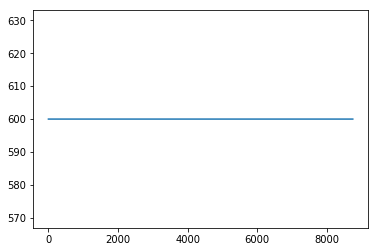

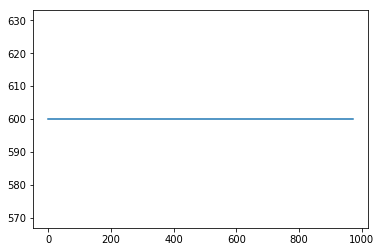

In [98]:


plt.plot(list(sorted(sequence_lens)))
plt.show()
plt.plot(list(sorted(test_sequence_lens)))

In [99]:
# code borrowed from lncNet repository for integer coding and bucketing

class CharacterTable(object): #make encoding table
    '''
    Given a set of characters:
    + Encode them to integer coding representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    #chars : 0 (padding ) + other characters
    '''
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, l):
        X = np.zeros((len(l)),dtype=np.int32)
        for i, c in enumerate(l):
            X[i]= self.char_indices[c]
    
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)
        


def dataset2buckets(sequence_lens, bucket_high_lims):
    
    # bucket of data indices
    buckets = [ [] for _ in bucket_high_lims]

    for i,len_x in enumerate( sequence_lens ):
        for b_id, bucket_len in enumerate(bucket_high_lims):
            if len_x <= bucket_len:
                # append the index of the data instead of the actual data
                buckets[b_id].append(i)  
                break

    return buckets

def seq2intcoding(seqs):
    X=[]
    for seq in seqs:
        enc = ctable.encode(seq)
        X.append(enc)
    
    X = np.array(X)
    
    return X

In [100]:
bucket_high_lims = [500*i for i in range(1,201)]
test_bucket_high_lims = [500*i for i in range(1,201)]


# do not pad if option not enabled
if not use_padding_for_bucketing:
    assert max(sequence_lens) == min(sequence_lens), "Sequence length varies; please enable bucketing"
    bucket_high_lims = [max(sequence_lens)]

    assert max(test_sequence_lens) == min(test_sequence_lens), "test_Sequence length varies; please enable bucketing"
    test_bucket_high_lims = [max(test_sequence_lens)]
    
    
chars= "0" + "".join(unique_DNAs)
ctable = CharacterTable(chars)

# integer coded sequences
seq_int_coded = seq2intcoding(sequences)
test_seq_int_coded = seq2intcoding(test_sequences)

# buckets containing  data indices
idxs_buckets = dataset2buckets(sequence_lens, bucket_high_lims)
used_buckets_idx, idxs_buckets  = zip(*[(i,idxs_buckets[i]) for i,b in enumerate(idxs_buckets) if b])

test_idxs_buckets = dataset2buckets(test_sequence_lens, test_bucket_high_lims)
test_used_buckets_idx, test_idxs_buckets  = zip(*[(i,test_idxs_buckets[i]) for i,b in enumerate(test_idxs_buckets) if b])


In [101]:
def create_seq_buckets(X, Y, idx_buckets, bucket_high_lims, used_buckets_idx, sequence_lens, use_features = False, features = None):    

    X_buckets = []
    X_buckets_padded = []
    Y_buckets = []
    X_buckets_packed = []
    
    sequence_lens = np.array(sequence_lens)
    #all_idxs = np.zeros(0)
    
    for b_id, idx_bucket in enumerate(idx_buckets):
        
        seq_lens_bucket = sequence_lens[idx_bucket]
        
        # ignore empty buckets
        if len(idx_bucket)==0:
            continue

        bucket_sz = len(idx_bucket)
        # indices of the data points in this bucket
        x_idxs = np.array(idx_bucket)
        
        #all_idxs = np.concatenate([all_idxs, x_idxs], axis = 0)
        
        # indices to the bucket contents (which is a set of indices as well - of data points)
        idx_in_bucket = np.arange(bucket_sz)
        
        X_bucket = X[x_idxs[idx_in_bucket]]
        Y_bucket = Y[x_idxs[idx_in_bucket]]
        
        X_bucket_T = [torch.Tensor(x) for x in X_bucket]
        #print(len(X_bucket_T))
        X_bucket_T.append(torch.zeros((bucket_high_lims[used_buckets_idx[b_id]],)))
        X_bucket_padded = pad_sequence(X_bucket_T, batch_first = True, padding_value = 0.0 )
        X_bucket_padded = X_bucket_padded.numpy()
        #print(X_bucket_padded.shape)
        # delete the last dummy row that served as element with padding length 
        X_bucket_padded = np.delete(X_bucket_padded, -1, axis = 0)        
        #print(X_bucket_padded.shape)
        
        X_bucket_padded=(np.arange(X_bucket_padded.max()+1) == X_bucket_padded[:,:,None]).astype(dtype='float32') #one_hot
        X_bucket_padded=np.delete(X_bucket_padded,0, axis=-1)
        #X_bucket = [X_bucket_padded[idx][:seq_lens_bucket[idx],:] for idx in range(X_bucket_padded.shape[0]) ]
        
        #X_buckets.append(X_bucket)
        if(use_features):
            X_bucket_padded = (X_bucket_padded, np.expand_dims(features[x_idxs[idx_in_bucket],:],-1) )  
            print(X_bucket_padded[0].shape, X_bucket_padded[1].shape)
        
        X_buckets_padded.append(X_bucket_padded)        
        Y_buckets.append(Y_bucket)
    
        #print(torch.Tensor(X_bucket_padded).shape)
        #sorted_lens = list(sorted(sequence_lens[idx_buckets[b_id]]))
        #print(sorted_lens[:10])
        
        # returns a packed sequences with #batches equal to the size of the maximum seq length, where a batch size
        # corresponds to how many sequences have a valid input at that time step
        #packed_input = pack_padded_sequence(torch.Tensor(X_bucket_padded), seq_lens_buckets, batch_first=True, enforce_sorted=False)
        #X_buckets_packed.append(packed_input)
        
    return X_buckets_padded,Y_buckets#, X_buckets_packed

In [102]:
if(not use_features):
    X_buckets, Y_buckets = create_seq_buckets(seq_int_coded, labels, idxs_buckets, bucket_high_lims, used_buckets_idx, sequence_lens, use_features)
    test_X_buckets, test_Y_buckets = create_seq_buckets(test_seq_int_coded, test_labels, test_idxs_buckets, test_bucket_high_lims, test_used_buckets_idx, test_sequence_lens, use_features)
else:
    X_buckets, Y_buckets = create_seq_buckets(seq_int_coded, labels, idxs_buckets, bucket_high_lims, used_buckets_idx, sequence_lens, use_features, features)
    test_X_buckets, test_Y_buckets = create_seq_buckets(test_seq_int_coded, test_labels, test_idxs_buckets, test_bucket_high_lims, test_used_buckets_idx, test_sequence_lens, use_features, test_features)
    


In [103]:
# for b_id in range(len(X_buckets)):
#     idxs_bucket = idx_buckets[b_id]
#     for rand_idx in np.random.randint(len(X_buckets[b_id]), size = 10):
#         print(X_buckets[b_id][rand_idx].shape, sequence_lens[idxs_bucket[rand_idx]])
        
#     print()

In [104]:
len(X_buckets), len(test_X_buckets),torch.cuda.is_available()

(1, 1, True)

In [105]:
len(idxs_buckets), len(test_idxs_buckets)

(1, 1)

In [106]:
# X_buckets[0][0][0,:].shape

In [107]:
def get_kmers(alphabet, k):
    kmers_list = []
    kmers_list.append(alphabet)
    
    for k_idx in range(k-1):
        kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

    seq_lst = list(seq)
    subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
    kmers = kmers_list[k-1]
    
    return kmers

def compute_kmer_counts(seq, k, do_sliding = True):
    alphabet = list(set(list(seq)))
    alphabet.sort()

#     kmers_list = []
#     kmers_list.append(alphabet)
    
#     for k_idx in range(k-1):
#         kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

#     seq_lst = list(seq)
#     subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
    kmers = get_kmers(alphabet, k)
    kmers_counts = [subs.count(kmer) for kmer in kmers]
    
    return kmers_counts

## sanity check 
[converting one-hot encoded sequences to DNA seq and checking against the corresponding original from the dataset]


In [108]:
# # sanity check [converting one-hot encoded sequences to DNA seq and checking against the corresponding original from the dataset]

def check_onehot_encoding_correctness(X_buckets, Y_buckets, unique_DNAs, sequences, sequence_lens, idxs_buckets):
    
    data_check_arr = []
    feature_check_arr = []
    incorrect_feature_match_indices = []

    for b_idx in range(len(X_buckets)):
        x_bucket_padded = X_buckets[b_idx]

        if(use_features):
            features_bucket = x_bucket_padded[1]
            x_bucket_padded = x_bucket_padded[0]

        y_bucket = Y_buckets[b_idx]
        idx_bucket = idxs_buckets[b_idx]

        for seq_idx in range(x_bucket_padded.shape[0]):
            seq_oh = x_bucket_padded[seq_idx,:,:]

            seq_str = "".join([unique_DNAs[dna_idx] for dna_idx in np.argmax(seq_oh, axis = -1)]) # convert from one-hot to DNA
            seq_str = seq_str[:sequence_lens[idx_bucket[seq_idx]]]  # get rid of the padding

            seq = sequences[idx_bucket[seq_idx]]  # original seq retrieved according to saved indices of the one-hot data

            if(use_features):
                idx_range = [[0,11],[12,59],[60,251]]
                feature_check_acc = []
                #seq = seq[-500:] + seq[:-500]
                for k in range(1,4):
                    kmer_counts1 = compute_kmer_counts(seq_str[:200], k)    
                    kmer_counts2 = compute_kmer_counts(seq_str[200:400], k)    
                    kmer_counts3 = compute_kmer_counts(seq_str[400:], k)    

                    features_computed= np.array(kmer_counts1+kmer_counts2+kmer_counts3)
                    features_from_file = features_bucket[seq_idx,idx_range[k-1][0]:idx_range[k-1][1]+1].squeeze()
                    feature_check = np.all( features_computed == features_from_file)
                    #print(feature_check)
                    #print(features_computed)
                    #print(features_from_file)
                    #print()
                    #print(features_bucket[seq_idx,idx_range[k-1][0]:idx_range[k-1][1]+1].squeeze())
                    #print()
                    feature_check_acc.append(feature_check)
                #print()    
                feature_check_arr.append(np.all(feature_check_acc))

                if not np.all(feature_check_acc):
                    #print(seq_idx)
                    incorrect_feature_match_indices.append(seq_idx)

            data_check_arr.append(seq == seq_str)


    print("One-hot encoding and bucketing is correct:", np.all(np.array(data_check_arr)))

    if(use_features):
        print("feature check is correct:", np.all(np.array(feature_check_arr)))    
    

In [111]:
# check_onehot_encoding_correctness(X_buckets, Y_buckets, unique_DNAs, sequences, sequence_lens, idxs_buckets)
# print("Now test set")
# check_onehot_encoding_correctness(test_X_buckets, test_Y_buckets, unique_DNAs, test_sequences, test_sequence_lens, test_idxs_buckets)


# incorrects = [sequences[idxs_buckets[0][i]] for i in incorrect_feature_match_indices]
# [print(incorrect,"\n\n") for incorrect in incorrects]

In [113]:
def merge_buckets(XY1, XY2, using_features):
    X1, Y1 = XY1[0], XY1[1]
    X2, Y2 = XY2[0], XY2[1]
    
    X_merged, Y_merged = [],[]
    for b_idx in range(len(X1)):
        if(using_features):
            seq1 = X1[b_idx][0]
            num1 = X1[b_idx][1]

            seq2 = X2[b_idx][0]
            num2 = X2[b_idx][1]
            num_bucket = np.concatenate([num1,num2],axis = 0)
        
        else:
            seq1 = X1[b_idx]
            seq2 = X2[b_idx]
        
        seq_bucket = np.concatenate([seq1,seq2],axis = 0)
        
        if(using_features):
            X_merged.append((seq_bucket, num_bucket))
        else:
            X_merged.append(seq_bucket)
        label1 = Y1[b_idx]    
        label2 = Y2[b_idx]    
        label_bucket = np.concatenate([label1, label2], axis =0)
        Y_merged.append(label_bucket)
        
            
    return X_merged, Y_merged

if(is_testing):
    merged_buckets_X, merged_buckets_Y = merge_buckets((X_buckets, Y_buckets), (test_X_buckets, test_Y_buckets), use_features)
    training_example_counts = [X_bucket.shape[0] for X_bucket in X_buckets] 
    test_example_counts = [test_X_bucket.shape[0] for test_X_bucket in test_X_buckets]
    X_buckets = merged_buckets_X
    Y_buckets = merged_buckets_Y
    
len(X_buckets[0]),X_buckets[0].shape, len(test_X_buckets[0]),test_X_buckets[0].shape, merged_buckets_X[0].shape, merged_buckets_Y[0].shape, training_example_counts, test_example_counts


(9719,
 (9719, 600, 4),
 973,
 (973, 600, 4),
 (9719, 600, 4),
 (9719,),
 [8746],
 [973])

In [115]:
len(idxs_buckets), len(test_idxs_buckets)

(1, 1)

In [116]:
## Verify that in a packed seq, batch_size equals the number of sequences having a valid input at (index+1) of the index batch_size in batch_sizes

# sequence_lens_np = np.array(sequence_lens)
# batch_size_idx = random.choice(range(len(X_buckets_packed[0].batch_sizes)))
# batch_size = X_buckets_packed[0].batch_sizes[batch_size_idx]
# batch_size.numpy() == np.sum(sequence_lens_np[idx_buckets[0]]>=(batch_size_idx+1))

In [117]:
# def compute_accuracy_metrics(y_true, y_pred, do_print = False):
#     accuracy = (y_true==y_pred).sum()/len(y_true)
    
#     cm = confusion_matrix(y_true, y_pred)
#     cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#     tn, fp, fn, tp = cm.ravel()

#     specificity = tn/(fp+tn)
#     sensitivity = tp/(tp+fn)
#     f1 = f1_score(y_true, y_pred)
#     recall = recall_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred)
#     auc_roc = roc_auc_score( y_true, y_pred )  

#     results = {'accuracy': accuracy, 'specificity':specificity, 'sensitivity':sensitivity, 'f1_score':f1, 'auc_roc':auc_roc, 'recall':recall, 'precision': precision}

#     if do_print:
#         for metric_name, metric_val in results.items():
#             print(metric_name,f'{metric_val:.2f}')
    
#     return results

class Metrics:
    
    def __init__(self, benchmark_acc = 0.0, benchmark_f1 = 0.0, benchmark_spec = 0.0, benchmark_sen = 0.0, benchmark_auc = 0.0):
        self.b_accuracy = benchmark_acc
        self.b_f1 = benchmark_f1
        self.b_sensitivity = benchmark_spec
        self.b_specificity = benchmark_sen
        self.b_auc_roc = benchmark_auc

    def reset_history(self):
        self.accuracies = []
        self.f1s = []
        self.recalls = []
        self.precisions = []
        self.sensitivity = []
        self.specificity = []
        self.auc_roc = []        
        self.tp_tn_fp_fn = []
        
    def compute_metrics(self, y_true, y_pred, epoch, do_print = False, store_vals = False):
        accuracy = (y_true==y_pred).sum()/len(y_true)
    
        cm = confusion_matrix(y_true, y_pred)
        #cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        tn, fp, fn, tp = cm.ravel()

        specificity = tn/(fp+tn)
        sensitivity = tp/(tp+fn)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        auc_roc = roc_auc_score( y_true, y_pred )  

        if(store_vals):
            self.accuracies.append(accuracy)
            self.specificity.append(specificity)
            self.sensitivity.append(sensitivity)
            self.f1s.append(f1)
            self.auc_roc.append(auc_roc)        
            self.recalls.append(recall)
            self.precisions.append(precision)
            self.tp_tn_fp_fn.append((tp, tn, fp, fn)) 
        
        results = {'accuracy': accuracy, 'specificity':specificity, 'sensitivity':sensitivity, 'f1_score':f1, 'auc_roc':auc_roc, 'recall':recall, 
                   'precision': precision, 'tp_fp_tn_fn':{'tp':tp, 'fp':fp, 'tn':tn, 'fn':fn} }
        
        
        if(do_print):
            is_beaten_acc = False
            is_beaten_f1 = False
            is_beaten_sens = False
            is_beaten_spec = False
            is_beaten_auc = False
            
            if( accuracy > self.b_accuracy ):
                is_beaten_acc = True
            
            if( f1 > self.b_f1 ):
                is_beaten_f1 = True
            
            if( sensitivity > self.b_sensitivity ):
                is_beaten_sens = True

            if( specificity > self.b_specificity ):
                is_beaten_spec = True

            if( auc_roc > self.b_auc_roc ):
                is_beaten_auc = True


            print(f'_________________________________________ METRICS for epoch {epoch} _______________________________________________________')
            print('accuracy '.ljust(16),f':{accuracy:.5f} ',f' bmark:({self.b_accuracy:.4f})',f' accuracy beaten:{is_beaten_acc}')
            print('f1_score '.ljust(16),f':{f1:.5f} ',f' bmark:({self.b_f1:.4f})',f' f1 beaten:{is_beaten_f1}')
            print('sensitivity '.ljust(16),f':{sensitivity:.5f} ',f' bmark:({self.b_sensitivity:.4f})',f' sen.beaten:{is_beaten_sens}')
            print('specificity '.ljust(16),f':{specificity:.5f} ',f' bmark:({self.b_specificity:.4f})',f' spe.beaten:{is_beaten_spec}')
            print('auc_roc '.ljust(16),f':{auc_roc:.5f} ',f' bmark:({self.b_auc_roc:.4f})',f' spe.beaten:{is_beaten_auc}')            
            
            print('precision '.ljust(16),f':{precision} ')
            print('recall '.ljust(16),f':{recall}')
            print( '---------------------') 
            print(f'| tp:{tp} '.ljust(9),f'| fp:{fp}'.ljust(9),'|')
            print(f'| fn:{fn} '.ljust(9),f'| tn:{tn}'.ljust(9),'|')
            print('---------------------') 

            if(is_beaten_acc and is_beaten_f1 and is_beaten_sens and is_beaten_spec and is_beaten_auc):
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
                print(f'##############################  BEATEN ALL at epoch:{epoch} ##############################################################')
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
        
        return results
    

In [118]:
# def make_model():
    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ sequential definition --------------------------------------------------------------------        
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     def make_seq_cnn():
#         # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

#         model = Sequential()

#         #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
#         model.add(Conv1D(filters=64, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) # input = 129 * 32
#         model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=48, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

# #         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
# #         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
# #         model.add(BatchNormalization())    
# #         model.add(Activation('relu'))
# #         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
# #         model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

#     #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#     #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
#     #     #model.add(BatchNormalization())    
#     #     model.add(Activation('relu'))
#     #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#     #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


#         #model.add(Bidirectional(LSTM(16, return_sequences=True)))
#         #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
#         #model.add(Dropout(rate = 0.4))    

#         model.add(Flatten())

#         #model.add(Dense(16))
#         #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
#         # […] The surface is smoother and transitions are more gradual
#         model.add(Dense(32, kernel_regularizer=l2(0.02) ) )
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.6)) 
#         model.add(Dense(2, kernel_regularizer=l2(0.02)))        
#         model.add(Activation('softmax'))
        
#         SGDRScheduler_config = { 'min_lr':2e-4,
#                                  'max_lr':.2e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 5,
#                                  'mult_factor': 1.5}
        
#         config = {'learning_rate':0.001, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]

    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ sequential definition --------------------------------------------------------------------        
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     def make_seq_3mer_cnn():
#         # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

#         model = Sequential()

#         model.add(Conv1D(filters=92, kernel_size=3 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) # input = 129 * 32
#         model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=48, kernel_size=3, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

# #         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
# #         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
# #         model.add(BatchNormalization())    
# #         model.add(Activation('relu'))
# #         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
# #         model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

#     #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#     #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
#     #     #model.add(BatchNormalization())    
#     #     model.add(Activation('relu'))
#     #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#     #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


#         #model.add(Bidirectional(LSTM(16, return_sequences=True)))
#         #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
#         #model.add(Dropout(rate = 0.4))    

#         model.add(Flatten())

#         #model.add(Dense(16))
#         #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
#         # […] The surface is smoother and transitions are more gradual
#         model.add(Dense(48, kernel_regularizer=l2(0.02) ) )
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.6)) 
#         model.add(Dense(2, kernel_regularizer=l2(0.02)))        
#         model.add(Activation('softmax'))
        
#         SGDRScheduler_config = { 'min_lr':2e-4,
#                                  'max_lr':5e-4,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 5,
#                                  'mult_factor': 1.5}
        
#         config = {'learning_rate':0.001, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]    
    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ sequential definition --------------------------------------------------------------------
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     def make_seq_cnn_blstm():
        
#         # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

#         model = Sequential()

#         #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
#         model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.4)) # input = 129 * 32
#         model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(8e-4), bias_regularizer=l2(8e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size =2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

#     #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#     #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
#     #     #model.add(BatchNormalization())    
#     #     model.add(Activation('relu'))
#     #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#     #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


#         #model.add(Bidirectional(LSTM(16, return_sequences=True)))
#         model.add(Bidirectional(CuDNNGRU(240, return_sequences=True, kernel_regularizer=l2(4e-3), recurrent_regularizer=l2(5e-3), bias_regularizer=l2(4e-3)) ))
#         model.add(Dropout(rate = 0.6))    

#         model.add(Flatten())

#         #model.add(Dense(16))
#         #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
#         # […] The surface is smoother and transitions are more gradual
#         model.add(Dense(16, kernel_regularizer=l2(0.01) ) )
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) 
#         model.add(Dense(2, kernel_regularizer=l2(0.01)))        
#         model.add(Activation('softmax'))
        
# #         SGDRScheduler_config = { 'min_lr':2e-4,
# #                                  'max_lr':.2e-3,
# #                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
# #                                  'lr_decay':0.95,
# #                                  'cycle_length': 5,
# #                                  'mult_factor': 1.5}

# #         SGDRScheduler_config = { 'min_lr':5e-4,
# #                                  'max_lr':.5e-3,
# #                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
# #                                  'lr_decay':0.95,
# #                                  'cycle_length': 2,
# #                                  'mult_factor': 1.5}        


#         SGDRScheduler_config = { 'min_lr':1e-4,
#                                  'max_lr': .5e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 2,
#                                  'mult_factor': 1.5}        
        
#         config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]    
    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ functional definition --------------------------------------------------------------------        
#     # -------------------------------------------------------------------------------------------------------------------------------------
    
#     def make_func_inception():
#         input_2d = Input(shape = ( inputSeqLength, totalNuclType ))

#         def create_inception_module(input_tensor):
#             c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
#             c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
#             c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
#             #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
#             #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
#             inception_module = Concatenate([c3, c5, c8], axis = 2)
            
            
#             #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
#             #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
#             #inception_module = c8

#             return inception_module

#         out = create_inception_module(input_2d)
#         #out = Dropout(rate = 0.1)(out)  # was 0.4
#         out = Dropout(rate = 0.4)(out)  # was 0.4
#         out = MaxPooling1D(pool_size = totalNuclType)(out)


#         out = create_inception_module(out)
#         #out = Dropout(rate = 0.1)(out) # was 0.4
#         out = Dropout(rate = 0.4)(out) # was 0.4
#         out = MaxPooling1D(pool_size = totalNuclType)(out)

#         out = Conv1D(filters=32, kernel_size=8)(out)
#         out = Activation('relu')(out)     
#         #out = Dropout(rate = 0.45)(out) # was 0.4
#         out = Dropout(rate = 0.4)(out) # was 0.4
#         out = MaxPooling1D(pool_size = totalNuclType)(out)

#     #     out = Bidirectional( LSTM(16, return_sequences=True))(out)
#     #     out = Bidirectional( LSTM(16, return_sequences=True))(out)    
#     #     out = Dropout(rate = 0.25)(out)

#         out = Flatten()(out)
#         out = Dense(16)(out)
#         out = Activation('relu')(out)
#         out = Dropout(rate = 0.5)(out)

#         #out = Dense(2, activation='softmax')(out)
#         out = Dense(1, activation='sigmoid')(out)

#         model = Model(inputs = input_2d, outputs = out)        
    
#         SGDRScheduler_config = { 'min_lr':3e-5,
#                                  'max_lr':1e-3,    #0.5e-3, #1e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(5*hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length':10,
#                                  'mult_factor': 1.0}
        
#         config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]
    
    
    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ functional definition --------------------------------------------------------------------        
#     # -------------------------------------------------------------------------------------------------------------------------------------
    
#     def make_func_inception_small():
#         input_2d = Input(shape = ( inputSeqLength, totalNuclType ))

#         def create_inception_module(input_tensor):
#             c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
#             c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
#             c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
#             #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
#             #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
#             inception_module = Concatenate([c3, c5, c8], axis = 2)
            
            
#             #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
#             #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
#             #inception_module = c8

#             return inception_module

#         def create_resnet_module(input_tensor):
#             c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
#             c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
#             c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
#             #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
#             #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
#             inception_module = Concatenate([c3, c5, c8, input_tensor], axis = 2)
            
            
#             #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
#             #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
#             #inception_module = c8

#             return inception_module        
        
#         out = create_inception_module(input_2d)
#         #out = Dropout(rate = 0.1)(out)  # was 0.4
#         out = Dropout(rate = 0.4)(out)  # was 0.4
#         out = MaxPooling1D(pool_size = 2)(out)
        
#         out = create_inception_module(out)
#         #out = Dropout(rate = 0.1)(out) # was 0.4
#         out = Dropout(rate = 0.5)(out) # was 0.4
#         out = MaxPooling1D(pool_size = 2)(out)   

# #         out = create_resnet_module(out)
# #         #out = Dropout(rate = 0.1)(out) # was 0.4
# #         out = Dropout(rate = 0.4)(out) # was 0.4
# #         out = MaxPooling1D(pool_size = totalNuclType)(out)   
        
#         out = Conv1D(filters=64, kernel_size=8, kernel_regularizer=l2(8e-4), bias_regularizer=l2(8e-4))(out)
#         #out = BatchNormalization()(out)
#         out = Activation('relu')(out)     
#         #out = Dropout(rate = 0.45)(out) # was 0.4
#         out = Dropout(rate = 0.6)(out) # was 0.5, and 0.4 before
#         out = MaxPooling1D(pool_size = 2)(out)

        
#         out = Bidirectional( LSTM(16, return_sequences=True))(out)
#         out = Bidirectional( LSTM(16, return_sequences=True))(out)    
#         out = Dropout(rate = 0.25)(out)

#         out = Flatten()(out)
#         out = Dense(16, kernel_regularizer=l2(0.02))(out)
#         out = BatchNormalization()(out)
#         out = Activation('relu')(out)
#         out = Dropout(rate = 0.7)(out) # was 0.5

#         #out = Dense(2, activation='softmax')(out)
#         out = Dense(1, activation='sigmoid')(out)

#         model = Model(inputs = input_2d, outputs = out)        
    
#         SGDRScheduler_config = { 'min_lr':3e-5,
#                                  'max_lr':0.5e-3,    #0.5e-3, #1e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(5*hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length':10,
#                                  'mult_factor': 1.0}
        
#         config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]    
    
    
#     return make_func_inception_small()

In [119]:
# https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797

class OneCycleCosineAnnealing:
    
    def __init__(self, optim, steps_per_cycle, cycles_per_round, max_lr = 1e-3, start_lr = None, end_lr = None, half_cycle_len_pct = .3, decay_rate = 1.0):
        init_div_factor, last_div_factor = 25.0, 1e4
        self.optim = optim
        self.max_lr = max_lr
        self.decay_rate = decay_rate
        self.cycles_per_round = cycles_per_round
        self.start_lr = self.max_lr/init_div_factor if start_lr is None else start_lr
        self.end_lr = self.max_lr/(init_div_factor*last_div_factor) if end_lr is None else end_lr
        for param_group in self.optim.param_groups:
            param_group['lr'] = self.start_lr
        self.steps_per_cycle = steps_per_cycle
        self.half_cycle_len_pct = half_cycle_len_pct
        self.peak_step_idx = int(self.steps_per_cycle*self.half_cycle_len_pct)
        print("self.start_lr",self.start_lr)
        print("self.max_lr",self.max_lr)
        print("self.end_lr",self.end_lr)
        
        self.coslr1 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.peak_step_idx, eta_min = self.max_lr)        
        self.coslr2 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.steps_per_cycle - self.peak_step_idx, eta_min = self.end_lr)
        self.step_idx = 0
        self.cycle_idx = 0
        self.lrs = []
        self.lrs.append(self.optim.param_groups[0]['lr'])
        
    def step(self):
        self.step_idx+=1
        if(self.step_idx < self.peak_step_idx):
            self.coslr1.step()  
        elif(self.step_idx <= self.steps_per_cycle):
            self.coslr2.step()
        else:
            self.cycle_idx +=1
            if(self.cycle_idx%self.cycles_per_round==0):
                self.max_lr*=self.decay_rate
            self.coslr1 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.peak_step_idx, eta_min = self.max_lr)  
            self.coslr2 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.steps_per_cycle - self.peak_step_idx, eta_min = self.end_lr)
            self.coslr1.step()           
            self.step_idx = 1
            
        self.lrs.append(self.optim.param_groups[0]['lr'])
        
            
# model = torch.nn.Linear(1, 1)

# max_lr = 1e-3
# init_lr = max_lr/25.0
# last_lr = max_lr/25e4


# num_epochs = 50

# optimizer = torch.optim.SGD(model.parameters(), lr = init_lr)

# for param_group in optimizer.param_groups:
#         param_group['lr'] = init_lr

# scheduler = OneCycleCosineAnnealing(optimizer, num_epochs, 5, max_lr = 1e-3, decay_rate = .95)

# lrs = []

# lrs.append(optimizer.param_groups[0]['lr'])    

# for _ in range(10*num_epochs):
#     #print("-", l.last_epoch, optim.param_groups[0]['lr'])
#     scheduler.step()    
#     lrs.append(optimizer.param_groups[0]['lr'])
# print("min:",min(lrs))        
# plt.plot(lrs)
# plt.show()

In [120]:
# class ListDataset(torch.utils.data.Dataset):
    
#     def __init__(self, data, label) -> None:
#         super().__init__()
#         self.data = data
#         self.label = label
        
#         assert len(self.data) == len(self.label)
    
#     def __getitem__(self, index):
#         return (self.data[index], self.label[index])
    
#     def __len__(self):
#         return len(self.data)
    

# The network
class RNA_Net(nn.Module):
    
    def __init__(self, num_features, hidden_sz):
        super(RNA_Net, self).__init__()
        
        self.num_features = num_features
        self.hidden_sz = hidden_sz
        self.lstm = nn.LSTM(input_size = num_features, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.batchnrm = nn.BatchNorm1d(hidden_sz)
        #self.linear = nn.Linear(in_features = hidden_sz, out_features= 2)
        self.linear2 = nn.Linear(in_features = 2*hidden_sz, out_features= 2)
        
#         for name, param in self.lstm.named_parameters():
#             if 'bias' in name:
#                 nn.init.constant_(param, 0.0)
#             elif 'weight' in name:
#                 nn.init.xavier_normal_(param)
        
    def forward(self, x, seq_lengths):
#         x_packed = pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
#         packed_out, (hn, cn) = self.lstm(x_packed)        
#         out, input_sizes = pad_packed_sequence(packed_out, batch_first=True)

        out, (hn, cn) = self.lstm(x)        
        l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        #l2allstates = self.batchnrm(l2allstates)
        net_out = self.linear2(l2allstates.view(-1, 2*self.hidden_sz))
        #net_out = self.linear2(last_state_cmbnd.view(-1, 2*self.hidden_sz))
        
        
        
        return net_out

    
class CNPPNet(nn.Module):
    
    def __init__(self, num_features, hidden_sz):
        super(CNPPNet, self).__init__()
        #super().__init__()
        
        self.hidden_sz = hidden_sz
        # inception layer 1
        self.conv11 = nn.Conv1d(num_features,64, kernel_size= 3, padding=1)
        self.conv12 = nn.Conv1d(num_features,64, kernel_size= 5, padding=2)
        self.conv13 = nn.Conv1d(num_features,32, kernel_size= 7, padding=3)
        
        # inception layer 2
        self.conv21 = nn.Conv1d(160,64, kernel_size= 3, padding=1)
        self.conv22 = nn.Conv1d(160,64, kernel_size= 5, padding=2)
        self.conv23 = nn.Conv1d(160,32, kernel_size= 7, padding=3)
        
        self.maxpool1d = torch.nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(160,32, kernel_size= 7)
        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.linear1 = nn.Linear(in_features = 32*7, out_features= 16)
        self.linear2 = nn.Linear(in_features = 16, out_features= 2)
 
        
    def forward(self,x):
        x = x.permute(0,2,1)
        
        #print(x.shape)
        out1 = self.conv11(x)
        out1 = F.relu(out1)
        out2 = self.conv12(x)
        out2 = F.relu(out2)
        out3 = self.conv13(x)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        
        out1 = self.conv21(out)
        out1 = F.relu(out1)
        out2 = self.conv22(out)
        out2 = F.relu(out2)
        out3 = self.conv23(out)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        out = self.conv3(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        #print(out.shape)
        #print(out.shape)
        
        out = self.linear1(out.view(-1, 32*7))
        out = F.dropout(out, p = 0.5)
        out = self.linear2(out)

        return out

    
class CNPPNet_Hybrid(nn.Module):
    
    def __init__(self, num_features, hidden_sz):
        super(CNPPNet_Hybrid, self).__init__()
        #super().__init__()
        
        self.hidden_sz = hidden_sz
        # inception layer 1
        self.conv11 = nn.Conv1d(num_features,64, kernel_size= 3, padding=1)
        self.conv12 = nn.Conv1d(num_features,64, kernel_size= 5, padding=2)
        self.conv13 = nn.Conv1d(num_features,32, kernel_size= 7, padding=3)
        
        # inception layer 2
        self.conv21 = nn.Conv1d(160,64, kernel_size= 3, padding=1)
        self.conv22 = nn.Conv1d(160,64, kernel_size= 5, padding=2)
        self.conv23 = nn.Conv1d(160,32, kernel_size= 7, padding=3)
        
        self.maxpool1d = torch.nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(160,32, kernel_size= 7)
        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        #self.linear1 = nn.Linear(in_features = 32*29 , out_features= 16)
        
        self.linear1 = nn.Linear(in_features = 32*29 + 64, out_features= 16)
        self.linear2 = nn.Linear(in_features = 16, out_features= 2)
 
        self.feature_linear1 = nn.Linear(in_features = 168, out_features= 128)
        self.feature_linear2 = nn.Linear(in_features = 128, out_features= 64)
        
        layers = [nn.BatchNorm1d(n_in)]
        layers.append(nn.Dropout(p))
        layers.append(nn.Linear(n_in, n_out))
        layers.append(actn)
        layers

        
    def forward(self,seq, features):
        x = seq.permute(0,2,1)
        features = features.permute(0,2,1)
#         print(x.type())
        
        out1 = self.conv11(x)
        out1 = F.relu(out1)
        out2 = self.conv12(x)
        out2 = F.relu(out2)
        out3 = self.conv13(x)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        
        out1 = self.conv21(out)
        out1 = F.relu(out1)
        out2 = self.conv22(out)
        out2 = F.relu(out2)
        out3 = self.conv23(out)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        out = self.conv3(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        
        #print(features.shape)
        feature_out = self.feature_linear1(features.view(-1,168))
        feature_out = self.feature_linear2(feature_out)
        
        
        combined_out = torch.cat((out.view(-1, 32*29),feature_out),1)
        #combined_out = torch.cat(out.view(-1, 32*29),1)
        out = self.linear1(combined_out)
        
        #out = self.linear1(out.view(-1, 32*29))
        out = F.dropout(out, p = 0.5)
        out = self.linear2(out)

        return out    
    
    
class CNNNet(nn.Module):
    # https://peltarion.com/static/vgg_pa03.jpg
    
    def __init__(self, num_features, hidden_sz):
        super(CNNNet, self).__init__()
        #super().__init__()
        
        self.hidden_sz = hidden_sz
        self.conv1 = nn.Conv1d(in_channels = num_features, out_channels = 32, kernel_size= 7)        
        self.conv2 = nn.Conv1d(in_channels = self.conv1.out_channels, out_channels = 64, kernel_size= 5)
        self.maxpool1d_2 = torch.nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(in_channels = self.conv2.out_channels,out_channels = 128, kernel_size= 3)        
        self.maxpool1d_4 = torch.nn.MaxPool1d(kernel_size=4)
        
        
        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.linear1 = nn.Linear(in_features = 128*36, out_features= 64)
        self.linear2 = nn.Linear(in_features = 64, out_features= 16)
        self.linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
        self.dropout = nn.Dropout(p =0.5)
    
    def forward(self,x):
        x = x.permute(0,2,1)
        
        #print(x.shape)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.maxpool1d_2(out)

        out = self.conv3(out)
        out = self.maxpool1d_4(out)        
        
        out = self.linear1(out.view(-1, 128*36))
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear3(out)

        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        #print(out.shape)
        #print(out.shape)
        
        

        return out

In [121]:
# import torch
# from matplotlib import pyplot as plt

# print("torch version: ", torch.__version__)

        
# model = torch.nn.Linear(1, 1)

# max_lr = 1e-3
# init_lr = max_lr/25.0
# last_lr = max_lr/25e4
# print("init_lr",init_lr)
# print("max_lr",max_lr)
# print("last_lr",last_lr)

# num_epochs = 20

# optim = torch.optim.SGD(model.parameters(), lr = init_lr)

# for param_group in optim.param_groups:
#         param_group['lr'] = init_lr

        

# l1 = lr_scheduler.CosineAnnealingLR(optim, T_max = num_epochs//3, eta_min = max_lr)
# lr2 = lr_scheduler.CosineAnnealingLR(optim, T_max = 2*num_epochs//3, eta_min = last_lr)
# #lr2 = lr_scheduler.StepLR(optim, gamma = 0.9, step_size = 2)
# lrs = []


# lrs.append(optim.param_groups[0]['lr'])    

# for _ in range(num_epochs):
#     #print("-", l.last_epoch, optim.param_groups[0]['lr'])
#     if(l1.last_epoch<num_epochs//3):
#         l1.step()        
#     else:
#         lr2.step()
#     lrs.append(optim.param_groups[0]['lr'])
# plt.plot(lrs)
# plt.show()

In [122]:
# tr_idxs = bucket_train_test_idxs[0][0]
# test_idxs = bucket_train_test_idxs[0][1]

# len(bucket_train_test_idxs[0][0]), len(bucket_train_test_idxs[0][1]), max(tr_idxs), min(test_idxs), max(test_idxs)

In [124]:
###### Setup K-fold X-validation

xval_fold_count =  10 
num_epochs =  100
batch_sz = 512

skf = StratifiedKFold( n_splits= xval_fold_count , random_state = 23, shuffle=True)

num_buckets = len(X_buckets)

bucket_train_test_idxs = []

use_xfolding = False

if(is_testing): 
    xval_fold_count = 1

# generating train_test indices for all k folds, for each bucket
for bucket_idx in range(num_buckets):
    #bucket_input_features = X_buckets[bucket_idx]
    
    #if(use_features):
    #    bucket_input_features = bucket_input_features[0]
        
    bucket_labels = Y_buckets[bucket_idx]
    
    train_test_idxs = list(skf.split(np.zeros(len(bucket_labels)), bucket_labels))
    if(not is_testing):
        bucket_train_test_idxs.append(train_test_idxs)
    else:
        bucket_train_test_idxs.append( np.expand_dims([list(range(training_example_counts[bucket_idx])), 
                                        list(range(training_example_counts[bucket_idx],training_example_counts[bucket_idx]+test_example_counts[bucket_idx]))],axis =0 ) )

In [125]:
# len(bucket_train_test_idxs[0][0])

In [129]:
init_learning_rate = 0.01    
    
## packing variable-length data in pytorch using packing and padding:
## https://github.com/HarshTrivedi/packing-unpacking-pytorch-minimal-tutorial

## https://gist.github.com/MikulasZelinka/9fce4ed47ae74fca454e88a39f8d911a

metrics_ht = Metrics(benchmark_acc = 0.8169, benchmark_f1 = 1.0, benchmark_spec = 0.8060, benchmark_sen = 0.8277, benchmark_auc = 1.0)

all_folds_last_results = []

for k in range(xval_fold_count):  # k-fold x-validation
    
    print("Fold",k)

    metrics_ht.reset_history()

    train_datasets = []
    val_datasets = []
    
    bucket_sampling_idxs = np.random.permutation(list(range(len(X_buckets))))
    
    training_seq_label_buckets = []
    val_seq_label_buckets = []
    training_num_features_buckets = []
    val_num_features_buckets = []
    
    # iterate through the buckets to create datasets and dataloaders
    for bucket_idx in bucket_sampling_idxs:

        train_idx = bucket_train_test_idxs[bucket_idx][k][0]
        val_idx = bucket_train_test_idxs[bucket_idx][k][1]
        idxs_in_bucket = np.array(idxs_buckets[bucket_idx])

        bucket_input_features = X_buckets[bucket_idx]
        bucket_labels = Y_buckets[bucket_idx]

        
        train_labels = bucket_labels[train_idx]
        val_labels = bucket_labels[val_idx]
        
        #train_data_idxs = idxs_in_bucket[train_idx]        
        #val_data_idxs = idxs_in_bucket[val_idx]
        
        if(use_features):
            train_features = (bucket_input_features[0][train_idx,:], bucket_input_features[1][train_idx,:])
            val_features = (bucket_input_features[0][val_idx], bucket_input_features[1][val_idx,:])

            training_seq_label_buckets.append( (train_features[0], train_labels) )
            val_seq_label_buckets.append( (val_features[0], val_labels) )
            
            training_num_features_buckets.append(train_features[1])
            val_num_features_buckets.append(val_features[1])
            #train_datasets.append(data_utils.TensorDataset(torch.from_numpy(train_features[0]), torch.from_numpy(train_features[1]).float(), torch.from_numpy(train_labels)))
            #val_datasets.append(data_utils.TensorDataset(torch.from_numpy(val_features[0]), torch.from_numpy(val_features[1]).float(), torch.from_numpy(val_labels)))
        else:
            train_features = bucket_input_features[train_idx,:]
            val_features = bucket_input_features[val_idx,:]

            train_datasets.append(data_utils.TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels)))
            val_datasets.append(data_utils.TensorDataset(torch.from_numpy(val_features), torch.from_numpy(val_labels)))
            
    # normalize numerical features combining data across buckets        
    if(use_features):        
        training_num_features = np.concatenate(training_num_features_buckets, axis = 0)
        mu = np.mean(training_num_features, axis = 0)
        sd = np.std(training_num_features, axis = 0)
        training_num_features_buckets = [ (training_num_features_bucket-mu)/sd for training_num_features_bucket in training_num_features_buckets]
                
        #training_num_features = (training_num_features - mu)/sd
        #val_num_features = np.concatenate(val_num_features_buckets, axis = 0)
        #val_num_features = (val_num_features - mu)/sd
        
        val_num_features_buckets = [ (val_num_features_bucket-mu)/sd for val_num_features_bucket in val_num_features_buckets]
        
        
        for bucket_idx in bucket_sampling_idxs:
            #print(training_seq_label_buckets[bucket_idx][0].shape)
            #print(training_num_features[bucket_idx].shape)
            #print(training_seq_label_buckets[bucket_idx][1].shape)

            train_datasets.append(data_utils.TensorDataset(torch.from_numpy(training_seq_label_buckets[bucket_idx][0]), 
                                                           torch.from_numpy(training_num_features_buckets[bucket_idx]).float(), 
                                                           torch.from_numpy(training_seq_label_buckets[bucket_idx][1])))
            
            val_datasets.append(data_utils.TensorDataset(torch.from_numpy(val_seq_label_buckets[bucket_idx][0]), 
                                                         torch.from_numpy(val_num_features_buckets[bucket_idx]).float(), 
                                                         torch.from_numpy(val_seq_label_buckets[bucket_idx][1])))


        
    train_dataloaders = [data_utils.DataLoader(train_dataset, batch_size = batch_sz, shuffle = True) for train_dataset in train_datasets]
    val_dataloaders = [data_utils.DataLoader(val_dataset, batch_size = batch_sz, shuffle = False) for val_dataset in val_datasets]

    num_iter_per_epoch = np.sum([len(loader) for loader in train_dataloaders])
    
    
    training_losses = []
    val_losses = []

    # initialize the model
    #model = RNA_Net(num_DNAs, 16).cuda()
    #model = CNPPNet(num_DNAs, 16).cuda()
    if(use_features):   
        model = CNPPNet_Hybrid(num_DNAs, 16).cuda()
    else:
        model = CNNNet(num_DNAs, 16).cuda()
        
    
    print(model)
    
    # loss function, optimization algorithm, and final layer activation function
    loss_function = torch.nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).cuda() )
    activationFunc = torch.nn.LogSoftmax(dim = -1)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3,  weight_decay=0.01)
    scheduler = OneCycleCosineAnnealing(optimizer, num_iter_per_epoch*num_epochs/7, 1, max_lr = 5e-3, decay_rate =.9)
    print(num_iter_per_epoch)
    
    model = model.train()
        
    # train the network 
    for epoch in range(num_epochs):
        print("Epoch",epoch,"started.")
        
        train_dataset_sizes = [len(train_dataloader.dataset) for train_dataloader in train_dataloaders]
        val_dataset_sizes = [len(val_dataloader.dataset) for val_dataloader in val_dataloaders]
        
        print("Training dataset size(s):",*train_dataset_sizes)
        print("Validation dataset size(s):",*val_dataset_sizes)
        
        training_loss = []
        train_ys = []
        train_preds = []
            
        # train the network                
        for train_dataloader in tqdm_notebook(train_dataloaders):
            
            for x, y in train_dataloader:
            #for x, z, y in train_dataloader:
                model.zero_grad()
                optimizer.zero_grad()
                
                x = x.cuda()
                #z = z.cuda()
                
                y = y.cuda()
                x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)
                
                torch.all(x !=0)
                # compute the length of each sequence in the batch (to be used for packing)
                # pad the sequences in the batch
                 
                #logits = model(x, seq_lengths = x_lens)
                
                logits = model(x)
                #logits = model(x, z)
                preds = torch.argmax(activationFunc(logits), dim = -1)
                
                loss = loss_function(logits, y)
                training_loss.append(loss.item())
                
                train_ys.append(y.cpu().numpy())
                train_preds.append(preds.cpu().numpy())
                    
                loss.backward()
                scheduler.step()
                optimizer.step()
                
        training_losses.append(np.mean(training_loss))        
        train_ys = np.concatenate(train_ys) 
        train_preds = np.concatenate(train_preds)
        
        print("Epoch",epoch,"completed.")
        
        #print('________________________________________')
        #print('Training metrics')
        #results = metrics_ht.compute_metrics(train_ys, train_preds, epoch, do_print = False)
        #print('training_accuracy:',results['accuracy'])
        #print('________________________________________')

        model = model.eval()
        # compute validation loss, and accuracy metrics        
        with torch.no_grad():
            val_ys = []

            val_pred_probs = []            
            val_preds = []
            
            val_loss = []
            
            for val_dataloader in val_dataloaders:
                for x, y in val_dataloader:
                #for x, z, y in val_dataloader:
                    x = x.cuda()
                    #z = z.cuda()
                    y = y.cuda()
                    x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)

                    #logits = model(x, seq_lengths = x_lens.cpu())                
                    
                    logits = model(x)                
                    #logits = model(x, z)                
                    log_pred_probs = activationFunc(logits)
                    preds = torch.argmax(log_pred_probs, dim = -1)
                    
                    loss = loss_function(logits, y)
                    val_loss.append(loss.item())
                    
                    val_ys.append(y.cpu().numpy())
                    val_preds.append(preds.cpu().numpy())
                    val_pred_probs.append(np.exp(log_pred_probs.cpu().numpy()))
            val_losses.append(np.mean(val_loss))
        
        
        val_ys = np.concatenate(val_ys) 
        val_preds = np.concatenate(val_preds)
        val_pred_probs = np.concatenate(val_pred_probs)
        
        #val_accuracy = (val_ys==val_preds).sum()/len(val_preds) 
        #print("--- validation accuracy:", val_accuracy)   
        print('============================================================================================================')
        print('Validation metrics')
        val_results = metrics_ht.compute_metrics(val_ys, val_preds, epoch, do_print = True, store_vals = True)
        print('============================================================================================================')
        #print('Training metrics')
        #results = metrics_ht.compute_metrics(train_ys, train_preds, epoch, do_print = True, store_vals = False)
        #print('============================================================================================================')
        
        line_colors = plt.cm.tab20(np.linspace(0,1,20))
        
        tr_loss_color = line_colors[0]
        val_loss_color = line_colors[2]
        
#         plt.cla()
#         plt.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
#         plt.legend()
#         plt.show();
        
        x_data = range(epoch+1)
        
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12,2))
        ax1.plot(x_data, training_losses, label="train loss", color = tr_loss_color, alpha=1.0)
        ax1.plot(x_data, val_losses, label="val_loss", color = val_loss_color, alpha=1.0)
        ax1.legend()
        ax1.set_title("Fold: "+str(k)+" epoch: "+str(epoch))
        
        #ax = fig.subplot(122), alpha=.7
        tmp = np.array(metrics_ht.tp_tn_fp_fn)
        ax2.plot(x_data, tmp[:,2], label="False Positive", color = tr_loss_color, alpha=1.0)
        ax2.plot(x_data, tmp[:,3], label="False Negatives", color = val_loss_color, alpha=1.0)
        ax2.legend()
        ax2.set_title("FP & FN Fold: "+str(k)+" epoch: "+str(epoch))
        
        
        ax3.plot(x_data, [metrics_ht.b_accuracy]*len(x_data), label="b_accuracy", color = 'r', alpha=.5)
        ax3.plot(x_data, [metrics_ht.b_sensitivity]*len(x_data), label="b_sensitivity", color = 'g', alpha=.5)
        ax3.plot(x_data, [metrics_ht.b_specificity]*len(x_data), label="b_specificity", color = 'b', alpha=.5)
        ax3.plot(x_data, [metrics_ht.b_f1]*len(x_data), label="b_f1_score", color = 'c', alpha=.5)
        ax3.plot(x_data, [metrics_ht.b_auc_roc]*len(x_data), label="b_auc_roc", color = 'k', alpha=.5)
        
        ax3.plot(x_data, metrics_ht.accuracies, '--', label="accuracy", color = 'r')
        ax3.plot(x_data, metrics_ht.sensitivity, '--',  label="sensitivity", color = 'g')
        ax3.plot(x_data, metrics_ht.specificity, '--',  label="specificity", color = 'b')
        ax3.plot(x_data, metrics_ht.f1s,  '--', label="b_f1_score", color = 'c')
        ax3.plot(x_data, metrics_ht.auc_roc,  '--', label="b_auc_roc", color = 'k')
                
        ax3.legend(loc='lower left')
        ax3.set_title("Acc-Sensitivity-Specificity-F1-AUC for Fold: "+str(k)+" epoch: "+str(epoch))
        
        ax4.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
        ax4.legend()
                
        plt.show()
        plt.close()
        
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    all_folds_last_results.append(val_results)

for result in all_folds_last_results:
    print(result)

In [142]:
now = datetime.now()
savefile_name = time = now.strftime("%H_%M_%S")+"_"+now.strftime("%m") + now.strftime("%d") + now.strftime("%Y")
# torch.save(model.state_dict(), f'./trained_model_{savefile_name}.pkl')    

# use to load and start inference:
# model.load_state_dict(torch.load(filepath))
# model.eval()

print("Test results")
for result in all_folds_last_results:
    print("accuracy:",result['accuracy'])
    print("sensitivity:",result['sensitivity'])
    print("specificity:",result['specificity'])

Test results
accuracy: 0.8612538540596094
sensitivity: 0.8726207906295754
specificity: 0.8344827586206897


In [130]:
def get_kmers(alphabet, k):
    kmers_list = []
    kmers_list.append(alphabet)
    
    for k_idx in range(k-1):
        kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

    seq_lst = list(seq)
    subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
    kmers = kmers_list[k-1]

    return kmers

def sequence2encodings(alphabet, sequence_lst):

    label_encodings = np.array([alphabet.index(c)+1  for seq in sequence_lst for c in seq ]).reshape(len(sequence_lst),-1)

    onehot_encodings=[(np.arange(len(alphabet)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

    onehot_encodings = np.array([np.delete(onehot,0, axis=-1) for onehot in onehot_encodings]).reshape(len(onehot_encodings),-1, len(alphabet))
        
    return label_encodings, onehot_encodings

def onehots2sequences(alphabet, onehot_encodings):

    for onehot_encoding in onehot_encodings: 
        assert onehot_encoding.shape[-1] ==len(alphabet), "One hot sequence must be batch_sz x seq_length x alphabet_sz"
    
    DNA_sequences = ["".join(seq_lst) for seq_lst in [[alphabet[i] for i in np.argmax(one_hot, axis = 1)] for one_hot in onehot_encodings ]]

    label_encodings = np.array([alphabet.index(c)+1  for seq in DNA_sequences for c in seq ]).reshape(len(DNA_sequences),-1)

    return DNA_sequences, label_encodings


def mutate_seq_for_saliencymap(sequence_to_mutate, window_sz, mutation_probs, mutation_rate_pct, stride = None, start_idx = 0, alphabet = None, include_identicals = False ):
    
    if stride is None or stride <= 0:
        stride = window_sz
        
    if alphabet is None:
        alphabet = list(sorted(list(set(list(sequence_to_mutate)))))
    
    seq_len = len(sequence_to_mutate)
    region_start_idxs = np.array(list(range(start_idx, seq_len, stride)))
    region_end_idxs = region_start_idxs + window_sz 
    #print(region_start_idxs, region_end_idxs, region_end_idxs>(seq_len))
    
    region_end_idxs[region_end_idxs>(seq_len)]=seq_len
    #print(region_start_idxs, region_end_idxs, )
    
    mutation_segments = [sequence_to_mutate[start:start+window_sz] for start in region_start_idxs]

    mutation_counts = [int(len(mutation_segment)*mutation_rate_pct) for mutation_segment in mutation_segments]
    #mutation_locations = [np.random.randint(0,len(mutation_segment), size=(1, mutation_count)) for mutation_segment,mutation_count in zip(mutation_segments, mutation_counts)]
    mutation_locations_segments = [[np.random.randint(0,len(mutation_segment), size=(1, mutation_count))] for mutation_segment, mutation_count in zip(mutation_segments, mutation_counts)]
    
    #print(alphabet, list(mutation_probs.values()))
    replacements_segments = [np.random.choice(alphabet, size = (mutation_count, ), p = list(mutation_probs.values())) for mutation_count in mutation_counts ]
    #print("mutation_locations_segments:", mutation_locations_segments)
    #print("replacements_segments:", replacements_segments)
    #print()
    mutated_segments = []
    for mutation_segment, mutation_locations_segment, replacements_segment in zip(mutation_segments, mutation_locations_segments, replacements_segments):
        #print("mutation_locations_segment",mutation_locations_segment)
        #print("replacements_segment",replacements_segment)
        mutation_locations_segment = np.array(mutation_locations_segment).reshape(1,)
        
        mutated_segment = list(mutation_segment[:]) 
        #print(mutated_segment)
        #
        for i_mloc, mloc in enumerate(np.array(mutation_locations_segment)):
            mutated_segment[mloc]=replacements_segment[i_mloc] 
        #    print("    ", mloc, replacements_segment[i_mloc] )
        #print(mutated_segment)
        mutated_segments.append("".join(mutated_segment))
        #print()
    
    mutated_sequence = sequence_to_mutate[:] # copy the sequence since strings are immutable
    
    for mutated_segment, start, end in zip(mutated_segments, region_start_idxs, region_end_idxs):
        #print(start,sequence_to_mutate, mutated_sequence[:start+1], mutated_segment, mutated_sequence[end:])
        mutated_sequence = mutated_sequence[:start] + mutated_segment + mutated_sequence[end:]
        #print(sequence_to_mutate)
        #print(mutated_sequence)
        #print()
    
    if not include_identicals:
        mutated_idxs = [i for i in range(len(sequence_to_mutate)) if sequence_to_mutate[i]!=mutated_sequence[i] ]
    else:
        mutated_idxs = list(range(len(sequence_to_mutate)))
        
    all_one_pos_change_sequences = []
    for i in mutated_idxs:
        all_one_pos_change_sequences.append("".join(list(sequence_to_mutate[:i])+list(mutated_sequence[i])+list(sequence_to_mutate[i+1:])))
    
    #return mutation_segments, mutated_segments, sequence_to_mutate, mutated_sequence, all_one_pos_change_sequences
    return sequence_to_mutate, mutated_sequence, all_one_pos_change_sequences
    
    
    
alphabet = unique_DNAs
kmers = get_kmers(alphabet, 2)

mutation_probs = {'eq':{'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }, 
                  'A': {'A': 1.,   'C': 0.,   'G': 0.,   'T': 0.,  },
                  'C': {'A': 0.,   'C': 1.,   'G': 0.,   'T': 0.,  },
                  'G': {'A': 0.,   'C': 0.,   'G': 1.,   'T': 0.,  },
                  'T': {'A': 0.,   'C': 0.,   'G': 0.,   'T': 1.,  },
                 }


# # # labelencodings, one_hots = sequence2encodings(alphabet, kmers)
# # # DNA_seqs, labelencodings_2 = onehots2sequences(alphabet, one_hots)

# # # DNA_seqs, kmers, labelencodings, labelencodings_2, one_hots
# # # "".join(list(map(chr,list(range(65,65+26)))))
# # #"".join(DNA_seqs)
# # #print(mut_segs),"".join(DNA_seqs), mutation_segments, mutated_segments
# # # print(mutation_segments)
# # # print(mutated_segments)
# # # print()

# test_seq = "AGCTATG"

# all_one_place_changes_for_all_DNA = []
# for DNA in unique_DNAs:
#     orig_seq, mut_seq, all_changed = mutate_seq_for_saliencymap(test_seq, 
#                                                                 window_sz = 1, 
#                                                                 mutation_probs = mutation_probs[DNA], 
#                                                                 mutation_rate_pct = 1., 
#                                                                 stride = 1, 
#                                                                 alphabet = unique_DNAs, 
#                                                                 include_identicals = True)
#     all_one_place_changes_for_all_DNA.extend(all_changed)
# len(all_one_place_changes_for_all_DNA), print(all_one_place_changes_for_all_DNA)


# # #[print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]    
# # #print(len(all_one_place_changes_for_all_DNA))
# # all_one_place_changes_for_all_DNA = list(sorted(list(set(all_one_place_changes_for_all_DNA))))    
# # #print(len(all_one_place_changes_for_all_DNA))
# # [print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]
# # print(orig_seq)
# # print(mut_seq)
# # print()
# # _, ohe = sequence2encodings(alphabet, mut_seq)
# # [print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]


# # #print(ohe)

In [131]:
# # # np.arange(one_hot[0].shape[1])[np.where(one_hot[0])]
# # one_hots.shape

# a = np.array([np.random.choice([1,2,3], p = [.8, .2, .0]) for _ in range(50)])
# a[a==1].shape[0], a[a==2].shape[0], a[a==1].shape[0]/a.shape[0], a[a==2].shape[0]/a.shape[0]

# np.random.randint(0,1,size=(1,10))

# a = [1,2,3,4]
# b = [5,6,7,8]

# c = ['A','B','C','D']

# for i,j,k in zip(a,b,c):
#     print(i,j,k)

# Saliency Map

In [132]:
# take the first bucket for now

bucket_idx = 0

X_onehots = val_datasets[bucket_idx][:][0]
Ys = val_datasets[bucket_idx][:][1]

X_seqs, X_label_encodings = onehots2sequences(unique_DNAs, X_onehots)
# print(len(X_seqs))

# verifying generated sequences and onehot conversion algorithm's correctness
# X_label_encodings, X_onehot_from_seq = sequence2encodings(unique_DNAs, X_seqs)
# torch.all(np.equal(X_onehot_from_seq[0], X_onehots[0])).item()

In [133]:
alphabet = unique_DNAs

# kmers = get_kmers(alphabet, 2)

mutation_probs = {'eq':{'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }, 
                  'A': {'A': 1.,   'C': 0.,   'G': 0.,   'T': 0.,  },
                  'C': {'A': 0.,   'C': 1.,   'G': 0.,   'T': 0.,  },
                  'G': {'A': 0.,   'C': 0.,   'G': 1.,   'T': 0.,  },
                  'T': {'A': 0.,   'C': 0.,   'G': 0.,   'T': 1.,  },
                 }

saliency_maps = dict()

for sample_class_label_int in [0,1]:  # for both negative and positive classes
    
    correct_classification_idxs_for_class = np.where(np.array(val_preds == val_ys) & np.array(val_ys == sample_class_label_int))[0].squeeze()

    sort_idxs = np.argsort(val_pred_probs[correct_classification_idxs_for_class, sample_class_label_int])
    best_performing_examples = correct_classification_idxs_for_class[sort_idxs]  # one with highest probability performing is at -1

    print(correct_classification_idxs_for_class.shape)
    print(val_pred_probs[correct_classification_idxs_for_class, sample_class_label_int].shape)
    print(best_performing_examples.shape)
    
    
    saliency_maps_for_class = []
    
    then = time.time() 
    for i_sample_idx, sample_idx in enumerate(best_performing_examples):
        if i_sample_idx%(len(best_performing_examples)//20) == 0:
            print(f"{i_sample_idx}/{len(best_performing_examples)}")
        sequence_to_mutate_idx = sample_idx #best_performing_examples[sample_idx] # one with highest probability performing is at -1
        sequence_to_mutate = X_seqs[sequence_to_mutate_idx]
        label_of_sequence_to_mutate = Ys[sequence_to_mutate_idx]

        #orig_seq, mut_seq, all_one_step_changed = mutate_seq_for_saliencymap( sequence_to_mutate, window_sz = 3, mutation_probs = mutation_probs[1], mutation_rate_pct = 0.5, stride = 3)

        all_one_step_changed = []
        for DNA in unique_DNAs:
            orig_seq, mut_seq, all_changed = mutate_seq_for_saliencymap( sequence_to_mutate, window_sz = 1, mutation_probs = mutation_probs[DNA], mutation_rate_pct = 1., stride = 1, alphabet = unique_DNAs,
                                                                       include_identicals=True)
            all_one_step_changed.extend(all_changed)


        _, X_onehot_mutated = sequence2encodings(unique_DNAs, [sequence_to_mutate]+all_one_step_changed)
        X_onehot_mutated.shape

        saliencyy_Xs = torch.from_numpy(X_onehot_mutated)
        saliency_Ys = torch.from_numpy(np.zeros(shape=(X_onehot_mutated.shape[0],), dtype=np.long)+label_of_sequence_to_mutate.item())
        saliency_data_idx = torch.from_numpy(np.arange(X_onehot_mutated.shape[0]))

        saliency_dataset = data_utils.TensorDataset(saliencyy_Xs, saliency_Ys, saliency_data_idx)

        len(saliency_dataset), type(saliencyy_Xs), type(saliency_Ys), saliency_Ys.shape, saliencyy_Xs.dtype, saliency_Ys.dtype

        saliency_loader_batch_sz = 512

        saliency_dataloader = data_utils.DataLoader(saliency_dataset, batch_size = saliency_loader_batch_sz, shuffle = False)


        model = model.eval()
        # compute validation loss, and accuracy metrics        
        with torch.no_grad():

            saliency_ys = []
            saliency_preds = []
            saliency_pred_probs = []
            saliency_loss = []
            saliency_losses = []

            saliency_x_idxs = []
            for saliency_x, saliency_y, saliency_x_batch_idxs in saliency_dataloader:
            #for x, z, y in val_dataloader:
                saliency_x = saliency_x.cuda()
                #z = z.cuda()
                saliency_y = saliency_y.cuda()
                #x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)

                #logits = model(x, seq_lengths = x_lens.cpu())                

                saliency_logits = model(saliency_x)                
                #logits = model(x, z)                
                saliency_log_pred_probs_batch = activationFunc(saliency_logits)
                saliency_preds_batch = torch.argmax(saliency_log_pred_probs_batch, dim = -1)

                #print(saleincy_logits.shape, saleincy_y.shape )
                saliency_loss_batch = loss_function(saliency_logits, saliency_y)

                saliency_loss.append(saliency_loss_batch.item())
                saliency_ys.append(saliency_y.cpu().numpy())
                saliency_pred_probs.append(np.exp(saliency_log_pred_probs_batch.cpu().numpy()))
                saliency_preds.append(saliency_preds_batch.cpu().numpy())
                saliency_x_idxs.append(saliency_x_batch_idxs)

            saliency_losses.append(np.mean(saliency_loss))


        saliency_ys = np.concatenate(saliency_ys) 
        saliency_preds = np.concatenate(saliency_preds)
        saliency_pred_probs = np.concatenate(saliency_pred_probs)
        saliency_x_idxs = np.concatenate(saliency_x_idxs)

        #sample_class_label_int
        #saliency_pred_probs[:5,sample_class_label_int], saliency_preds[:5], np.unique(saliency_ys), label_of_sequence_to_mutate, val_pred_probs[best_performing_examples[-1],sample_class_label_int]
        score_diff = saliency_pred_probs[:, sample_class_label_int] - saliency_pred_probs[0, sample_class_label_int]

        saliency_map = score_diff[1:].reshape(1,-1).reshape(len(unique_DNAs), len(orig_seq))
        score_diff
        saliency_maps_for_class.append(saliency_map)

    now = time.time()
    print(f"Time taken for class{sample_class_label_int}:{now-then} seconds")
    # plot saliency matrix
    saliency_maps[sample_class_label_int] = saliency_maps_for_class
    
    

(242,)
(242,)
(242,)
0/242
12/242
24/242
36/242
48/242
60/242
72/242
84/242
96/242
108/242
120/242
132/242
144/242
156/242
168/242
180/242
192/242
204/242
216/242
228/242
240/242
Time taken for class0:87.25416946411133 seconds
(596,)
(596,)
(596,)
0/596
29/596
58/596
87/596
116/596
145/596
174/596
203/596
232/596
261/596
290/596
319/596
348/596
377/596
406/596
435/596
464/596
493/596
522/596
551/596
580/596
Time taken for class1:213.53317070007324 seconds


# Plot Saliency maps

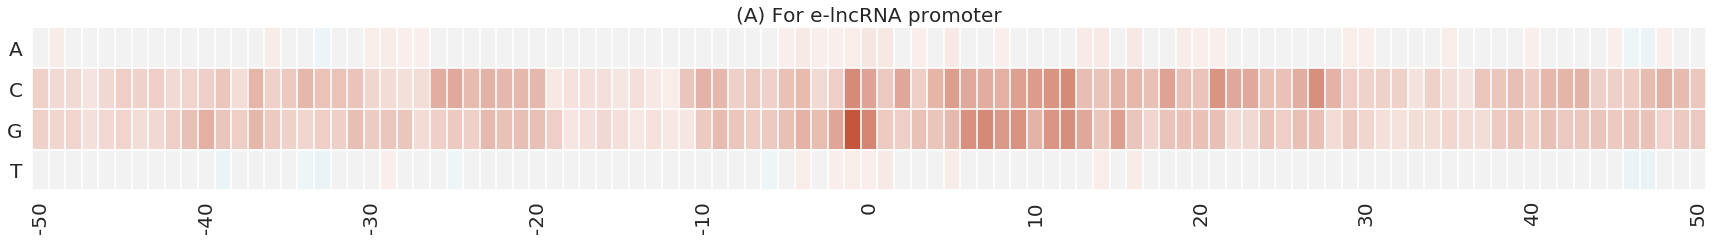

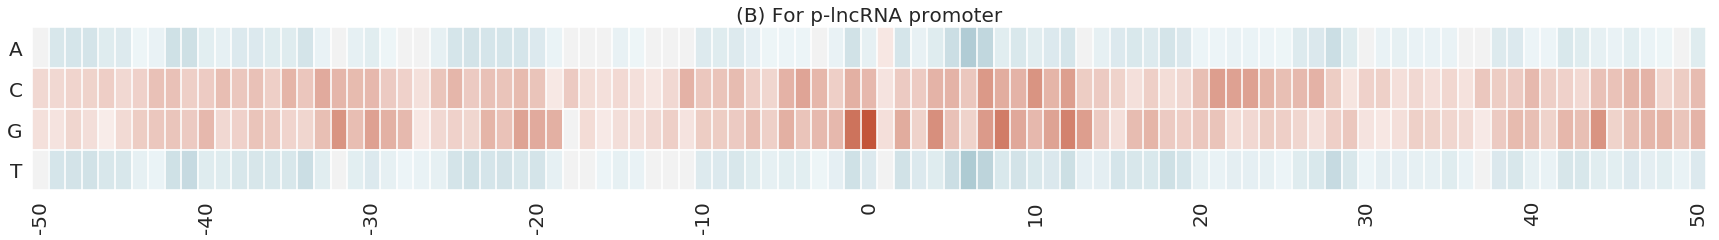

In [144]:
for sample_class_label_int in [0,1]:    
    score_multipliers = [-1.,1.]
    saliency_map = np.mean(np.array(saliency_maps[sample_class_label_int]), axis = 0) 
    saliency_map *= score_multipliers[sample_class_label_int]
    #print("saliency_map shape:", saliency_map.shape)
    #print(f'For class {class_names[sample_class_label_int]}')
    sns.set()
    #sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})

    span_min = 350
    span_max = 450 + 1
    label_min = span_min - 400
    label_max = label_min + (span_max-span_min) + 1
    plt.figure(figsize=(30,3))
    # sns_cmap = sns.palplot(sns.diverging_palette(240, 10, n=9, as_cmap = True))
    ax= sns.heatmap(saliency_map[:,span_min:span_max], 
                cmap = sns.diverging_palette(220,20, n=250, as_cmap = True), 
                vmax = np.max(saliency_map[:,span_min:span_max]), 
                vmin = np.min(saliency_map[:,span_min:span_max]), 
                center = 0.0, 
                cbar=False)

    #ax.set_aspect("equal")

    plt.grid(True, color='r', linestyle='--', linewidth=2, which = 'both')
    loc = ticker.MultipleLocator(base=2)
    ax.xaxis.set_minor_locator(loc)
    ax.yaxis.set_minor_locator(loc)

    plt.xticks(np.arange(0,span_max-span_min,10)+0.5, np.arange(label_min,label_max,10), fontsize=20)
    plt.yticks(np.arange(0,saliency_map.shape[0])+0.5, unique_DNAs, fontsize=20)
    #ax.set_yticklabels(ax.get_yticklabels(), rotation=0)x sssssssssdem  n
    plt.yticks(rotation=0)
    plt.title("(" + chr(65+sample_class_label_int) + f") For {class_names[sample_class_label_int]} promoter", fontsize=20)
    # ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
    # ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator())
    # ax.grid(b=True, which='major', color='w', linewidth=10.0)
    # ax.grid(b=True, which='minor', color='w', linewidth=15)
    gridlinewidth = 1.6
    ax.hlines(np.arange(len(unique_DNAs)+1), *ax.get_xlim(), color='w', linewidth=gridlinewidth)
    ax.vlines(np.arange(0,span_max-span_min+1), *ax.get_ylim(), color='w', linewidth=gridlinewidth)
    plt.show()


In [47]:
time.time()

1564594892.1464412

In [48]:
# plt.figure(figsize=(15,18))
# plt.imshow(saliency_map[:,350:450], cmap = 'Blues')
# plt.axis('off')

# Plot saliency map

In [49]:
np.arange(len(unique_DNAs)+1)+gridlinewidth/2

array([0.8, 1.8, 2.8, 3.8, 4.8])

In [50]:
# plt.imshow(saliency_map[:,:20], cmap = sns.diverging_palette(220,20, n=250, as_cmap = True))

In [51]:
# ax = sns.heatmap(saliency_map[:,:20], cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True))
# # plt.hist(saliency_map.reshape(1,-1), bins= np.linspace(np.min(saliency_map), np.max(saliency_map)))

In [52]:
# np.min(saliency_map)

In [53]:
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import seaborn as sbn

# x = np.linspace(0, 2 * np.pi, 100)
# y = np.sin(x)

# fig, ax = plt.subplots(1, 1)

# ax.scatter(x, y)
# ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax.grid(b=True, which='major', color='w', linewidth=1.0)
# ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [54]:
# from matplotlib import pyplot as plt
# from matplotlib.ticker import MultipleLocator
# import numpy as np

# # Two example plots
# fig = plt.figure(figsize=(18,12))
# ax1 = fig.add_subplot(2,2,1)
# ax2 = fig.add_subplot(2,2,2)

# spacing = 0.5 # This can be your user specified spacing. 
# minorLocator = MultipleLocator(spacing)
# ax1.plot(9 * np.random.rand(10))
# # Set minor tick locations.
# ax1.yaxis.set_minor_locator(minorLocator)
# ax1.xaxis.set_minor_locator(minorLocator)
# # Set grid to use minor tick locations. 
# ax1.grid(which = 'minor')

# spacing = 1
# minorLocator = MultipleLocator(spacing)
# ax2.plot(9 * np.random.rand(10))
# # Set minor tick locations.
# ax2.yaxis.set_minor_locator(minorLocator)
# ax2.xaxis.set_minor_locator(minorLocator)
# # Set grid to use minor tick locations. 
# ax2.grid(which = 'minor')

# plt.show()

In [55]:
# #val_accuracy = (val_ys==val_preds).sum()/len(val_preds) 
# #print("--- validation accuracy:", val_accuracy)   
# print('============================================================================================================')
# print('Validation metrics')
# val_results = metrics_ht.compute_metrics(val_ys, val_preds, epoch, do_print = True, store_vals = True)
# print('============================================================================================================')
# #print('Training metrics')
# #results = metrics_ht.compute_metrics(train_ys, train_preds, epoch, do_print = True, store_vals = False)
# #print('============================================================================================================')

# line_colors = plt.cm.tab20(np.linspace(0,1,20))

# tr_loss_color = line_colors[0]
# val_loss_color = line_colors[2]

# #         plt.cla()
# #         plt.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
# #         plt.legend()
# #         plt.show();

# x_data = range(epoch+1)

# f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12,2))
# ax1.plot(x_data, training_losses, label="train loss", color = tr_loss_color, alpha=1.0)
# ax1.plot(x_data, val_losses, label="val_loss", color = val_loss_color, alpha=1.0)
# ax1.legend()
# ax1.set_title("Fold: "+str(k)+" epoch: "+str(epoch))

# #ax = fig.subplot(122), alpha=.7
# tmp = np.array(metrics_ht.tp_tn_fp_fn)
# ax2.plot(x_data, tmp[:,2], label="False Positive", color = tr_loss_color, alpha=1.0)
# ax2.plot(x_data, tmp[:,3], label="False Negatives", color = val_loss_color, alpha=1.0)
# ax2.legend()
# ax2.set_title("FP & FN Fold: "+str(k)+" epoch: "+str(epoch))


# ax3.plot(x_data, [metrics_ht.b_accuracy]*len(x_data), label="b_accuracy", color = 'r', alpha=.5)
# ax3.plot(x_data, [metrics_ht.b_sensitivity]*len(x_data), label="b_sensitivity", color = 'g', alpha=.5)
# ax3.plot(x_data, [metrics_ht.b_specificity]*len(x_data), label="b_specificity", color = 'b', alpha=.5)
# ax3.plot(x_data, [metrics_ht.b_f1]*len(x_data), label="b_f1_score", color = 'c', alpha=.5)
# ax3.plot(x_data, [metrics_ht.b_auc_roc]*len(x_data), label="b_auc_roc", color = 'k', alpha=.5)

# ax3.plot(x_data, metrics_ht.accuracies, '--', label="accuracy", color = 'r')
# ax3.plot(x_data, metrics_ht.sensitivity, '--',  label="sensitivity", color = 'g')
# ax3.plot(x_data, metrics_ht.specificity, '--',  label="specificity", color = 'b')
# ax3.plot(x_data, metrics_ht.f1s,  '--', label="b_f1_score", color = 'c')
# ax3.plot(x_data, metrics_ht.auc_roc,  '--', label="b_auc_roc", color = 'k')

# ax3.legend(loc='lower left')
# ax3.set_title("Acc-Sensitivity-Specificity-F1-AUC for Fold: "+str(k)+" epoch: "+str(epoch))

# ax4.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
# ax4.legend()

# plt.show()
# plt.close()

# Motif (PWM) generation from Conv1 layers n_dictxL filter weights*all L-length subsequences, keeping the ones that leads to activations greater than half of the maximum activation, and computing the probability # of each nucleotide at each of L position of the subsequence. Only consider motifs of length 6 or greater

[torch.Size([32, 4, 7]), torch.Size([32]), torch.Size([64, 32, 5]), torch.Size([64]), torch.Size([128, 64, 3]), torch.Size([128]), torch.Size([64, 4608]), torch.Size([64]), torch.Size([16, 64]), torch.Size([16]), torch.Size([2, 16]), torch.Size([2])]
['A', 'C', 'G', 'T']
Filter shape: torch.Size([4, 7])
Layer 0, filter#0
 [[0.25 0.25 0.25 0.25 0.25 0.25 0.  ]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.  ]
 [0.25 0.25 0.25 0.25 0.25 0.25 1.  ]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.  ]]



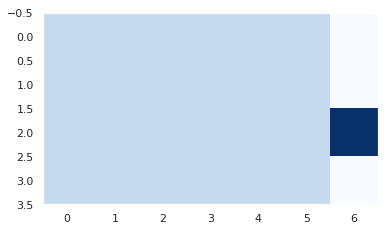

Filter shape: torch.Size([4, 7])
Layer 0, filter#1
 [[0.29990357 0.29411765 0.         0.72613308 0.09353905 0.36258438
  0.19575699]
 [0.10414658 0.21890068 1.         0.05207329 0.34136933 0.17936355
  0.20443587]
 [0.33847637 0.27097396 0.         0.         0.25650916 0.3442623
  0.31726133]
 [0.25747348 0.21600771 0.         0.22179364 0.30858245 0.11378978
  0.28254581]]



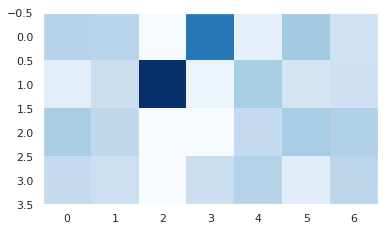

Filter shape: torch.Size([4, 7])
Layer 0, filter#2
 [[0.07301587 0.0015873  0.0015873  0.0031746  0.0984127  0.12063492
  0.16825397]
 [0.31587302 0.81587302 0.28095238 0.41269841 0.33809524 0.45873016
  0.36031746]
 [0.37301587 0.10634921 0.66507937 0.57619048 0.48253968 0.33968254
  0.21904762]
 [0.23809524 0.07619048 0.05238095 0.00793651 0.08095238 0.08095238
  0.25238095]]



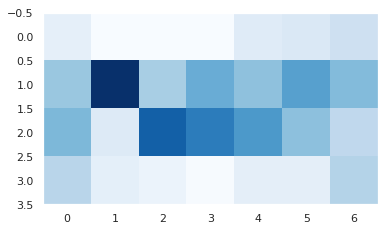

Filter shape: torch.Size([4, 7])
Layer 0, filter#3
 [[0.19300912 0.00607903 0.00151976 0.36930091 0.34802432 0.35410334
  0.32978723]
 [0.22492401 0.99240122 0.00607903 0.22340426 0.19452888 0.17933131
  0.2112462 ]
 [0.24012158 0.00151976 0.98176292 0.1656535  0.14133739 0.15349544
  0.15805471]
 [0.34194529 0.         0.0106383  0.24164134 0.31610942 0.31306991
  0.30091185]]



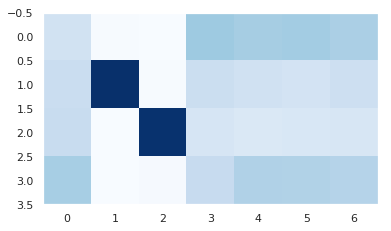

Filter shape: torch.Size([4, 7])
Layer 0, filter#4
 [[0.37092391 0.54755435 0.29211957 0.39402174 0.00679348 0.16440217
  0.13722826]
 [0.14538043 0.14945652 0.25543478 0.24456522 0.91032609 0.00951087
  0.10733696]
 [0.13994565 0.05434783 0.14402174 0.0951087  0.0298913  0.79619565
  0.47826087]
 [0.34375    0.2486413  0.30842391 0.26630435 0.05298913 0.0298913
  0.27717391]]



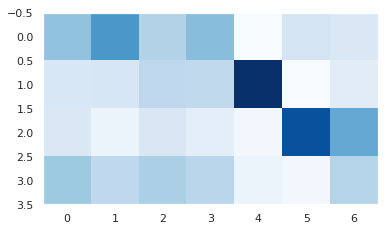

Filter shape: torch.Size([4, 7])
Filter shape: torch.Size([4, 7])
Layer 0, filter#6
 [[0.30966952 0.28518972 0.07099143 0.03916769 0.13219094 0.07588739
  0.28151775]
 [0.54345165 0.03059976 0.1750306  0.75764994 0.00244798 0.2619339
  0.45777234]
 [0.11505508 0.12729498 0.39412485 0.16401469 0.69889841 0.42227662
  0.1370869 ]
 [0.03182375 0.55691554 0.35985312 0.03916769 0.16646267 0.23990208
  0.12362301]]



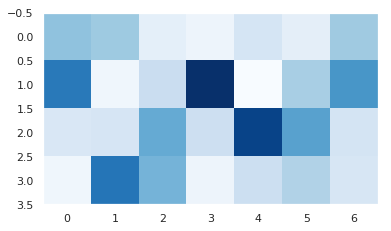

Filter shape: torch.Size([4, 7])
Layer 0, filter#7
 [[0.28695652 0.2173913  0.00483092 0.22705314 0.22608696 0.21835749
  0.38454106]
 [0.16135266 0.18647343 0.88405797 0.         0.2        0.59227053
  0.11594203]
 [0.28115942 0.20676329 0.02318841 0.73719807 0.19710145 0.09661836
  0.25024155]
 [0.2705314  0.38937198 0.08792271 0.03574879 0.37681159 0.09275362
  0.24927536]]



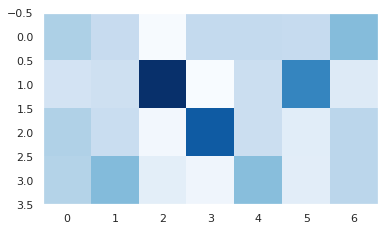

Filter shape: torch.Size([4, 7])
Layer 0, filter#8
 [[0.15660685 0.03915171 0.         0.         0.20880914 0.29853181
  0.22838499]
 [0.33768352 0.34257749 1.         0.         0.3278956  0.28874388
  0.31647635]
 [0.23327896 0.37357259 0.         1.         0.26264274 0.17781403
  0.21207178]
 [0.27243067 0.24469821 0.         0.         0.20065253 0.23491028
  0.24306688]]



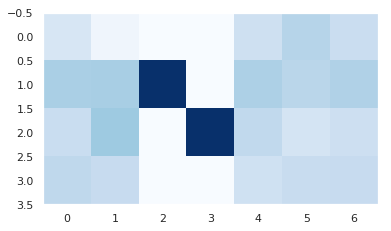

Filter shape: torch.Size([4, 7])
Layer 0, filter#9
 [[0.28624079 0.23734644 0.24299754 0.26977887 0.01597052 0.2995086
  0.22235872]
 [0.22874693 0.26388206 0.26633907 0.2017199  0.95208845 0.22457002
  0.22751843]
 [0.22874693 0.25970516 0.25798526 0.25749386 0.01597052 0.23783784
  0.26977887]
 [0.25626536 0.23906634 0.23267813 0.27100737 0.01597052 0.23808354
  0.28034398]]



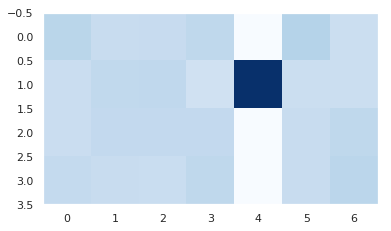

Filter shape: torch.Size([4, 7])
Layer 0, filter#10
 [[0.30608696 0.30086957 0.50086957 0.48347826 0.02608696 0.30086957
  0.15130435]
 [0.1826087  0.         0.08       0.13391304 0.48521739 0.48521739
  0.02782609]
 [0.4        0.00347826 0.18956522 0.20521739 0.         0.15826087
  0.02782609]
 [0.11130435 0.69565217 0.22956522 0.1773913  0.48869565 0.05565217
  0.79304348]]



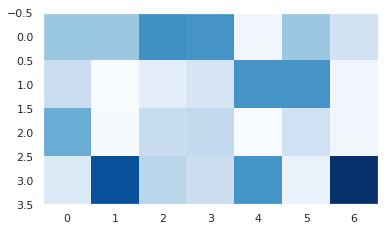

Filter shape: torch.Size([4, 7])
Layer 0, filter#11
 [[0.         0.         0.24703557 0.25395257 0.24901186 0.24110672
  0.25296443]
 [1.         0.00197628 0.25494071 0.25395257 0.25494071 0.25197628
  0.25296443]
 [0.         0.99802372 0.25296443 0.24703557 0.24703557 0.25197628
  0.23913043]
 [0.         0.         0.24505929 0.24505929 0.24901186 0.25494071
  0.25494071]]



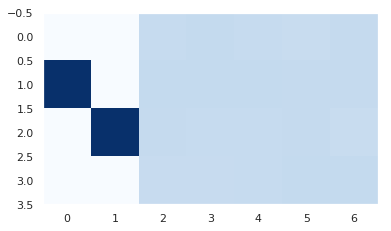

Filter shape: torch.Size([4, 7])
Layer 0, filter#12
 [[0.02325581 0.04318937 0.27408638 0.20099668 0.31893688 0.19767442
  0.49501661]
 [0.91528239 0.01993355 0.53322259 0.25747508 0.49169435 0.15448505
  0.31395349]
 [0.05813953 0.82890365 0.10631229 0.30232558 0.09800664 0.30730897
  0.0448505 ]
 [0.00332226 0.10797342 0.08637874 0.23920266 0.09136213 0.34053156
  0.1461794 ]]



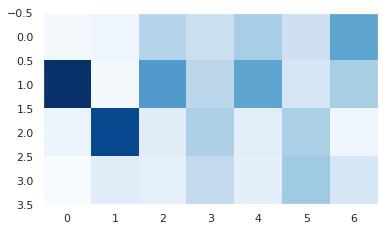

Filter shape: torch.Size([4, 7])
Layer 0, filter#13
 [[0.23987915 0.30755287 0.00151057 0.24018127 0.24954683 0.27069486
  0.24441088]
 [0.31238671 0.15679758 0.00151057 0.26374622 0.31299094 0.26344411
  0.25347432]
 [0.24471299 0.22175227 0.99546828 0.23716012 0.20694864 0.22114804
  0.26193353]
 [0.20302115 0.31389728 0.00151057 0.25891239 0.2305136  0.24471299
  0.24018127]]



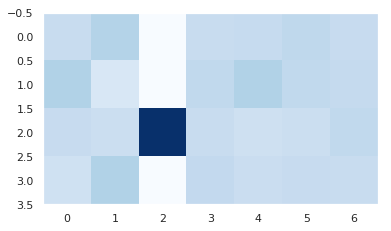

Filter shape: torch.Size([4, 7])
Layer 0, filter#14
 [[0.13490364 0.03640257 0.         0.00214133 0.10278373 0.21841542
  0.16059957]
 [0.24625268 0.49678801 0.97216274 0.00856531 0.44539615 0.3875803
  0.35331906]
 [0.25695931 0.30406852 0.00428266 0.97430407 0.25695931 0.15417559
  0.29978587]
 [0.36188437 0.1627409  0.0235546  0.01498929 0.19486081 0.23982869
  0.1862955 ]]



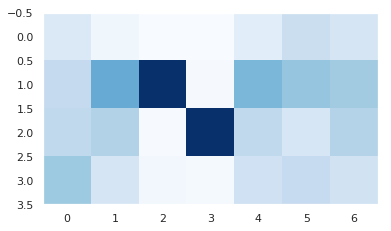

Filter shape: torch.Size([4, 7])
Layer 0, filter#15
 [[0.24931507 0.28219178 0.22648402 0.2630137  0.27031963 0.
  0.91506849]
 [0.24292237 0.22374429 0.31598174 0.21369863 0.21369863 1.
  0.        ]
 [0.24292237 0.22374429 0.23105023 0.2739726  0.25479452 0.
  0.02922374]
 [0.26484018 0.27031963 0.22648402 0.24931507 0.26118721 0.
  0.05570776]]



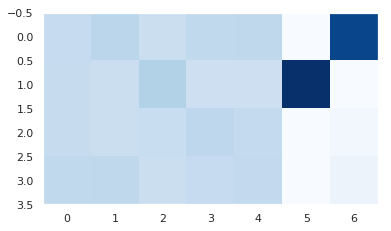

Filter shape: torch.Size([4, 7])
Layer 0, filter#16
 [[0.00118765 0.54513064 0.07244656 0.2280285  0.20546318 0.06769596
  0.1152019 ]
 [0.84441805 0.3087886  0.10451306 0.09382423 0.04631829 0.25771971
  0.25178147]
 [0.1543943  0.00356295 0.20902613 0.56294537 0.31947743 0.36935867
  0.37767221]
 [0.         0.14251781 0.61401425 0.1152019  0.42874109 0.30522565
  0.25534442]]



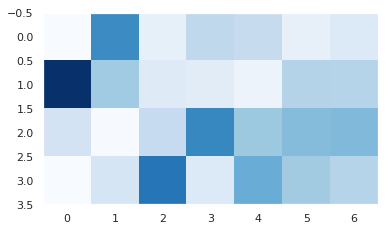

Filter shape: torch.Size([4, 7])
Layer 0, filter#17
 [[0.40827338 0.41906475 0.16906475 0.01618705 0.00359712 0.37230216
  0.33633094]
 [0.12230216 0.12230216 0.22841727 0.96582734 0.00719424 0.21223022
  0.21043165]
 [0.13309353 0.16906475 0.20323741 0.01438849 0.98381295 0.16007194
  0.14388489]
 [0.33633094 0.28956835 0.39928058 0.00359712 0.00539568 0.25539568
  0.30935252]]



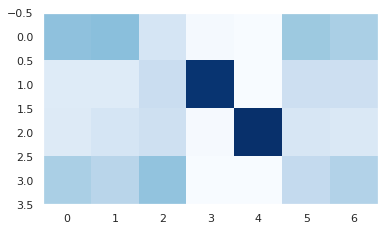

Filter shape: torch.Size([4, 7])
Layer 0, filter#18
 [[0.30530973 0.21681416 0.1460177  0.36725664 0.         0.10619469
  0.15929204]
 [0.50884956 0.         0.0619469  0.55309735 0.00442478 0.7920354
  0.48230088]
 [0.13274336 0.51769912 0.52654867 0.01327434 0.99115044 0.00442478
  0.03982301]
 [0.05309735 0.26548673 0.26548673 0.06637168 0.00442478 0.09734513
  0.31858407]]



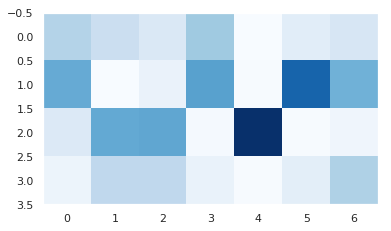

Filter shape: torch.Size([4, 7])
Layer 0, filter#19
 [[0.3255814  0.19069767 0.         0.         0.36589147 0.33023256
  0.34263566]
 [0.23255814 0.21395349 0.99844961 0.00310078 0.2372093  0.18914729
  0.20930233]
 [0.17829457 0.26976744 0.00155039 0.99379845 0.15658915 0.1379845
  0.14573643]
 [0.26356589 0.3255814  0.         0.00310078 0.24031008 0.34263566
  0.30232558]]



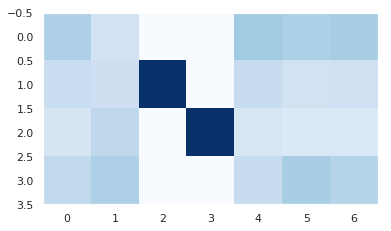

Filter shape: torch.Size([4, 7])
Layer 0, filter#20
 [[0.24629418 0.24173318 0.13568985 0.         0.         0.23147092
  0.27023945]
 [0.2713797  0.21322691 0.29418472 0.995439   0.         0.27366021
  0.2713797 ]
 [0.24857469 0.2668187  0.29418472 0.004561   1.         0.26339795
  0.22234892]
 [0.23375143 0.27822121 0.27594071 0.         0.         0.23147092
  0.23603193]]



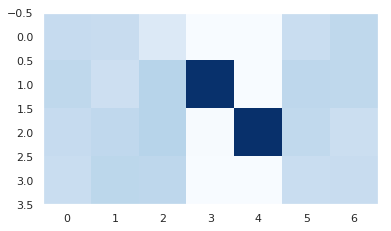

Filter shape: torch.Size([4, 7])
Layer 0, filter#21
 [[0.0227027  0.07351351 0.27351351 0.39243243 0.34378378 0.29405405
  0.23459459]
 [0.85081081 0.01621622 0.17621622 0.24324324 0.11675676 0.26918919
  0.21189189]
 [0.04864865 0.89297297 0.17837838 0.17513514 0.18378378 0.18810811
  0.04432432]
 [0.07783784 0.0172973  0.37189189 0.18918919 0.35567568 0.24864865
  0.50918919]]



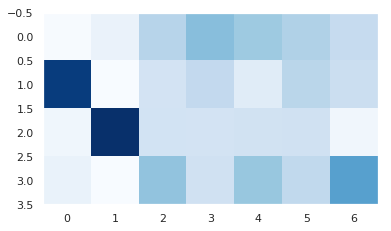

Filter shape: torch.Size([4, 7])
Layer 0, filter#22
 [[0.41440501 0.16597077 0.22338205 0.08872651 0.02505219 0.5480167
  0.29958246]
 [0.03235908 0.00939457 0.30480167 0.60438413 0.34864301 0.12108559
  0.12317328]
 [0.20041754 0.71189979 0.21189979 0.         0.61482255 0.07411273
  0.37891441]
 [0.35281837 0.11273486 0.25991649 0.30688935 0.01148225 0.25678497
  0.19832985]]



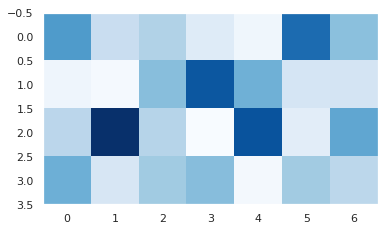

Filter shape: torch.Size([4, 7])
Layer 0, filter#23
 [[0.20642202 0.11009174 0.43577982 0.11009174 0.06116208 0.10244648
  0.12385321]
 [0.28287462 0.33639144 0.05657492 0.         0.00458716 0.59021407
  0.72782875]
 [0.34556575 0.1941896  0.22018349 0.46788991 0.90519878 0.10244648
  0.05045872]
 [0.16513761 0.35932722 0.28746177 0.42201835 0.02905199 0.20489297
  0.09785933]]



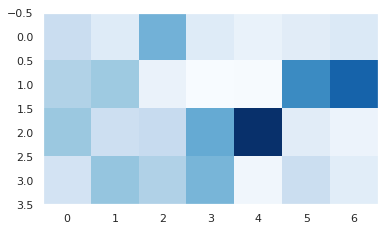

Filter shape: torch.Size([4, 7])
Layer 0, filter#24
 [[0.1796875  0.0109375  0.125      0.215625   0.378125   0.22890625
  0.20703125]
 [0.22734375 0.94921875 0.0046875  0.2796875  0.265625   0.2078125
  0.28359375]
 [0.26640625 0.0234375  0.79609375 0.2734375  0.16953125 0.1765625
  0.3265625 ]
 [0.3265625  0.01640625 0.07421875 0.23125    0.18671875 0.38671875
  0.1828125 ]]



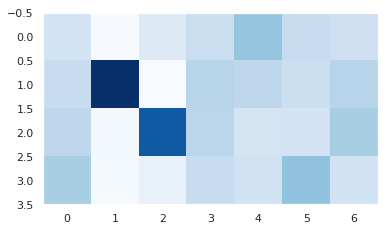

Filter shape: torch.Size([4, 7])
Layer 0, filter#25
 [[0.25583756 0.22030457 0.         0.         0.25279188 0.25685279
  0.24974619]
 [0.22538071 0.25989848 1.         0.         0.25482234 0.25583756
  0.24974619]
 [0.25888325 0.25989848 0.         1.         0.25279188 0.23959391
  0.24670051]
 [0.25989848 0.25989848 0.         0.         0.23959391 0.24771574
  0.25380711]]



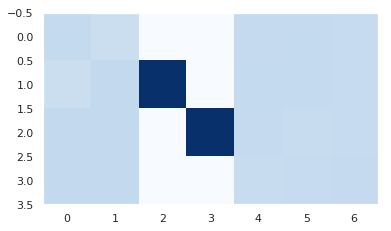

Filter shape: torch.Size([4, 7])
Layer 0, filter#26
 [[0.25 0.25 0.25 0.   0.25 0.25 0.25]
 [0.25 0.25 0.25 0.   0.25 0.25 0.25]
 [0.25 0.25 0.25 1.   0.25 0.25 0.25]
 [0.25 0.25 0.25 0.   0.25 0.25 0.25]]



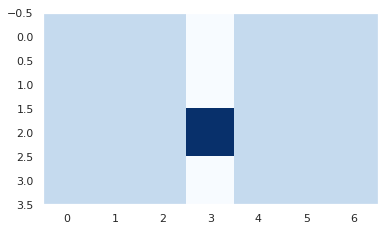

Filter shape: torch.Size([4, 7])
Layer 0, filter#27
 [[0.08927173 0.11589663 0.01957713 0.4596711  0.22317933 0.22631167
  0.24197338]
 [0.50039154 0.82537197 0.08770556 0.14487079 0.14800313 0.23962412
  0.20281911]
 [0.28191073 0.         0.78856695 0.2083007  0.19498825 0.29130775
  0.26624902]
 [0.128426   0.0587314  0.10415035 0.1871574  0.43382929 0.24275646
  0.2889585 ]]



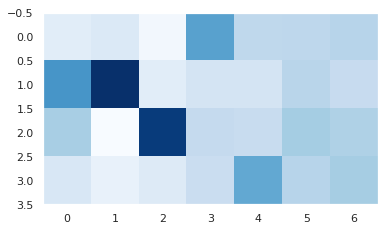

Filter shape: torch.Size([4, 7])
Layer 0, filter#28
 [[0.20238095 0.00744048 0.         0.35416667 0.32291667 0.35119048
  0.32440476]
 [0.20535714 0.99255952 0.00297619 0.24702381 0.17261905 0.17708333
  0.20982143]
 [0.24255952 0.         0.98660714 0.16815476 0.20535714 0.14583333
  0.1547619 ]
 [0.34970238 0.         0.01041667 0.23065476 0.29910714 0.32589286
  0.3110119 ]]



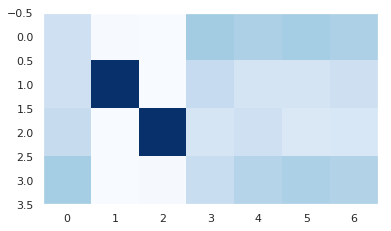

Filter shape: torch.Size([4, 7])
Layer 0, filter#29
 [[0.19348055 0.         0.         0.26077813 0.25867508 0.2681388
  0.24185068]
 [0.2681388  1.         0.         0.2681388  0.24710831 0.26077813
  0.24921136]
 [0.26919033 0.         1.         0.24395373 0.25236593 0.22712934
  0.25026288]
 [0.26919033 0.         0.         0.22712934 0.24185068 0.24395373
  0.25867508]]



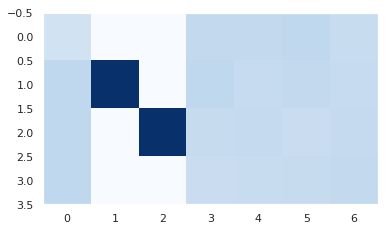

Filter shape: torch.Size([4, 7])
Layer 0, filter#30
 [[0.02016129 0.76008065 0.02217742 0.69556452 0.09677419 0.24193548
  0.11693548]
 [0.86693548 0.02016129 0.38306452 0.07459677 0.24395161 0.25604839
  0.08266129]
 [0.10080645 0.         0.38709677 0.17943548 0.25403226 0.33266129
  0.56451613]
 [0.01209677 0.21975806 0.20766129 0.05040323 0.40524194 0.16935484
  0.2358871 ]]



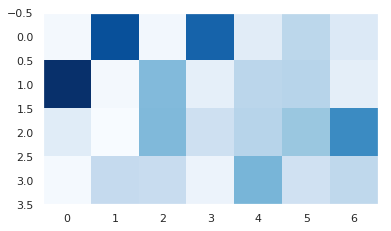

Filter shape: torch.Size([4, 7])
Layer 0, filter#31
 [[0.40557276 0.1873065  0.01547988 0.00928793 0.36377709 0.35294118
  0.32198142]
 [0.07120743 0.20278638 0.96130031 0.00309598 0.1749226  0.19349845
  0.15634675]
 [0.2120743  0.26006192 0.01702786 0.9876161  0.21362229 0.1625387
  0.1996904 ]
 [0.31114551 0.3498452  0.00619195 0.         0.24767802 0.29102167
  0.32198142]]



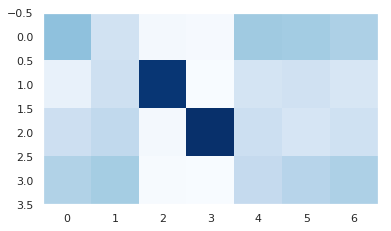

In [84]:




params = list(model.parameters())
print([param.shape for param in params])

# params[0][0]
print(unique_DNAs)

for l in range(0,6,2): # first layer conv filters only
    param_layer = params[l]

    for i, filter_weights in enumerate(param_layer):

        if(filter_weights.shape[1] < 6):
            continue
        print("Filter shape:",filter_weights.shape)
        filter_length = filter_weights.shape[1]
        filter_weights = filter_weights.data.permute(1,0)

        motif_sequences = get_kmers(unique_DNAs,filter_length)

        label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

        ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

        ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
        #print(ohs.shape)
        #print(filter_weights.shape)
        vals = (ohs*filter_weights.cpu())


        activisions = torch.nn.functional.relu(torch.sum(torch.sum(vals,1),1))

        #activisions[np.where(activisions > max(activisions)/2)], max(activisions)/2
        
        passed_sequences_idx = np.where(activisions > max(activisions)/2)[0]
        if(len(passed_sequences_idx) <=1):
            continue
        passed_sequences = [label_encodings[i] for i in passed_sequences_idx.squeeze()]
        passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]

        #passed_sequences, print(passed_sequences_motif)

        arr = np.array(passed_sequences).squeeze().transpose(1,0)
        probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences) for i in np.unique(label_encodings) ]
        print(f"Layer {l//2}, filter#{i}\n",np.array(probs).squeeze())
        print()
        plt.imshow(np.array(probs).squeeze(), cmap = plt.get_cmap('Blues') )
        
        plt.grid(False)
        #plt.grid(True, color='w', linestyle='-', linewidth=2, which = 'both')
        #loc = ticker.MultipleLocator(base=2)
        #ax.xaxis.set_minor_locator(loc)
        #ax.yaxis.set_minor_locator(loc)

        #plt.xticks(np.arange(0,filter_weights.shape[0])+0.5, np.arange(1,filter_weights.shape[0] + 1), fontsize=20)
        #plt.yticks(np.arange(0,filter_weights.shape[1])+0.5, unique_DNAs, fontsize=20)
        #ax.set_yticklabels(ax.get_yticklabels(), rotation=0)x sssssssssdem  n
        #plt.yticks(rotation=0)
        gridlinewidth = 1.6
        ax.hlines(np.arange(len(unique_DNAs)+1), *ax.get_xlim(), color='r', linewidth=gridlinewidth)
        ax.vlines(np.arange(0,filter_weights.shape[0]+1), *ax.get_ylim(), color='w', linewidth=gridlinewidth)
        plt.show()
        

# params = list(model.parameters())
# print([param.shape for param in params])

# # params[0][0]
# print(unique_DNAs)



# for l in range(0,6,2): # first layer conv filters only
#     param_layer = params[l]

#     for i, filter_weights in enumerate(param_layer):

#         if(filter_weights.shape[1] < 6):
#             continue
#         print("Filter shape:",filter_weights.shape)
#         filter_length = filter_weights.shape[1]
#         filter_weights = filter_weights.data.permute(1,0)

#         motif_sequences = get_kmers(unique_DNAs,filter_length)

#         label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

#         ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

#         ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
#         #print(ohs.shape)
#         #print(filter_weights.shape)
#         vals = (ohs*filter_weights.cpu())


#         activisions = torch.nn.functional.relu(torch.sum(torch.sum(vals,1),1))

#         #activisions[np.where(activisions > max(activisions)/2)], max(activisions)/2
        
#         passed_sequences_idx = np.where(activisions > max(activisions)/2)[0]
#         if(len(passed_sequences_idx) ==0):
#             continue
#         passed_sequences = [label_encodings[i] for i in passed_sequences_idx.squeeze()]
#         passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]

#         #passed_sequences, print(passed_sequences_motif)

#         arr = np.array(passed_sequences).squeeze().transpose(1,0)
#         probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences) for i in np.unique(label_encodings) ]
#         print(f"Layer {l//2}, filter#{i}\n",np.array(probs).squeeze())
#         print()
#         plt.imshow(np.array(probs).squeeze(), cmap = plt.get_cmap('jet') )
#         plt.grid('off')
        
#         plt.show()
        

In [73]:
passed_sequences_idx

array([15589])

In [ ]:
# params = list(model.parameters())
# [param.shape for param in params]
# params[0][0]
# print(unique_DNAs)

# l = 0
# param_layer = params[l]

# for i, filter_weights in enumerate(param_layer):
#     print("Filter shape:",filter_weights.shape)
#     filter_length = filter_weights.shape[1]
#     filter_weights = filter_weights.data.permute(1,0)
    
#     motif_sequences = get_kmers(unique_DNAs,filter_length)

#     label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

#     ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

#     ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
#     #print(ohs.shape)
#     #print(filter_weights.shape)
    
#     activisions = torch.nn.functional.relu(torch.sum(torch.sum(vals,1),1))

#     activisions[np.where(activisions > max(activisions)/2)], max(activisions)/2

#     passed_sequences_idx = np.where(activisions > max(activisions)/2)[0]
#     passed_sequences = [label_encodings[i] for i in passed_sequences_idx.squeeze()]
#     passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]

#     #passed_sequences, print(passed_sequences_motif)

#     arr = np.array(passed_sequences).squeeze().transpose(1,0)
#     probs = [np.sum(arr==i, axis = 1)/len(passed_sequences) for i in np.unique(label_encodings) ]
#     print(f"Layer {l//2}, filter#{i}\n",np.array(probs).squeeze())
#     print()

In [ ]:
# torch.cuda.is_available(), logits.shape

In [ ]:
# accuracy =  [result['accuracy'] for result in all_folds_last_results]
# np.mean(accuracy)    

In [ ]:
# sensitivity =  [result['sensitivity'] for result in all_folds_last_results]
# np.mean(sensitivity)    

In [ ]:
# specificity =  [result['specificity'] for result in all_folds_last_results]
# np.mean(specificity)    

In [ ]:
# from tqdm import trange
# from random import random, randint
# from time import sleep

# with trange(10) as t:
#     for i in t:
#         # Description will be displayed on the left
#         t.set_description('GEN %i' % i)
#         # Postfix will be displayed on the right,
#         # formatted automatically based on argument's datatype
#         t.set_postfix(loss=random(), gen=randint(1,999), str='h',
#                       lst=[1, 2])
#         sleep(0.1)

# with tqdm(total=10, bar_format="{postfix[0]} {postfix[1][value]:>8.2g}",
#           postfix=["Batch", dict(value=0)]) as t:
#     for i in range(10):
#         sleep(0.1)
#         t.postfix[1]["value"] = i / 2
#         t.update()

In [ ]:
# from tqdm import tqdm
# for i in tqdm(range(100000000)):
#     pass

In [ ]:
# from tqdm import tnrange, tqdm_notebook
# from time import sleep

# for i in tnrange(3, desc='1st loop'):
#     for j in tqdm_notebook(range(100), desc='2nd loop'):
#         sleep(0.01)

In [ ]:
# from tqdm import trange
# from random import random, randint
# from time import sleep

# with trange(10) as t:
#     for i in t:
#         # Description will be displayed on the left
#         t.set_description('GEN %i' % i)
#         # Postfix will be displayed on the right,
#         # formatted automatically based on argument's datatype
#         t.set_postfix(loss=random(), gen=randint(1,999), str='h',
#                       lst=[1, 2])
#         sleep(0.1)

# with tqdm_notebook(total=10, bar_format="{postfix[0]} {postfix[1][value]:>8.2g}",
#           postfix=["Batch", dict(value=0)]) as t:
#     for i in range(10):
#         sleep(0.1)
#         t.postfix[1]["value"] = i / 2
#         t.update()

In [ ]:
# len(val_dataloader.dataset)